# 10. Evolutionary analysis
## 10.1 Load the phylogenetic Project file

In [1]:
from reprophylo import *
import cloud.serialization.cloudpickle as pickle
import time, itertools

pj = unpickle_pj('TE_counts/18S_tree_reprophylo_project_with_TE', git=False)

DEBUG:Cloud:Log file (/home/amir/.picloud/cloud.log) opened
DEBUG:Cloud:Deleting 21104.log (63.9084765586 days old)
DEBUG:Cloud:Deleting 21104.lock (63.9084765586 days old)
DEBUG:Cloud:Deleting 12391.lock (63.8980642441 days old)
DEBUG:Cloud:Deleting 29883.lock (64.777671158 days old)
DEBUG:Cloud:Deleting 29883.log (64.777671158 days old)
DEBUG:Cloud:Deleting 12391.log (63.8980642441 days old)


## 10.2 Delete leaves of species with unpublished genomes from the phylobayes tree

In [2]:
# remove Acan, Asim, Bpah, Btim, Ever, Sbat, Tcan 
# from 18S@SINA@gappyout@dna_cat_gtr, but do not save this project

[Acan, Asim, Bpah, Btim, Ever, Sbat, Tcan] = [pj.trees['18S@SINA@gappyout@dna_cat_gtr'][0].search_nodes(keep=i)[0] for i in
                                            ['Acan', 'Asim', 'Bpah', 'Btim', 'Ever', 'Sbat', 'Tcan']]
for n in [Acan, Asim, Bpah, Btim, Ever, Sbat, Tcan]:
    n.delete()
    
for n in [Acan, Asim, Bpah, Btim, Ever, Sbat, Tcan]:
    print n.keep, n.feature_id

Acan denovo133_f0
Asim denovo177_f0
Bpah denovo178_f0
Btim denovo179_f0
Ever denovo128_f0
Sbat denovo134_f0
Tcan denovo185_f0


## 10.3 Make a chain file with trees without leaves of unpublished species genomes
The file is `./18S_tree/phylobayes/wo_wtsi.1.treelist`

In [3]:
# Make a posterior distribution of trees without wtsi

## Write the corrected trees here:
trees_wo_wtsi = open('./18S_tree/phylobayes/wo_wtsi.1.treelist','wt')

## Get the name of the root node:
hduj_id = pj.ft('18S@SINA@gappyout@dna_cat_gtr').search_nodes(keep="Hduj")[0].name

## Iterate the trees of phylobayes chain 1, remove the leaves and write to the new file
with open('./18S_tree/phylobayes/822861429729532.25_18S@SINAR@gappyout.1.treelist','r') as trees:
    for t in trees:
        T = Tree(t)
        for n in [Acan, Asim, Bpah, Btim, Ever, Sbat, Tcan]:
            (T&n.feature_id).delete()
        T.set_outgroup(hduj_id)
        T.dist=0
        trees_wo_wtsi.write('%s\n'%T.write(format=5))
trees_wo_wtsi.close()

returning tree object 18S@SINA@gappyout@dna_cat_gtr


## 10.4 Test  the TE Kappa Delta and Lambda on a subset of the chain 1 trees

In [6]:
import pandas as pd

# Load the superfamily counts dictionary
# as a source for superfamily names, not counts,
# and put them in the all_TEs list
pickle_file_name = 'TE_counts/family_counts.pkl'
pickle_handle = open(pickle_file_name, 'rb')
keys = pickle.pickle.load(pickle_handle)
all_TEs = set(itertools.chain(*[keys[i] for i in keys.keys()]))

# Add the class names to all_TEs
all_TEs = ['DNA','LTR','LINE','SINE'] + list(all_TEs)

# Sort by descending counts, exclude superfamilies
# that are 'unclassified' or '?' and occur in less than 
# 15 Nematoda species
TEs = sorted([key for key in all_TEs if
              not 'Unclassified' in key and
              not '?' in key and
              len([r for r in pj.records if any([key in f.qualifiers.keys() for f in r.features])]) > 14 ],
             
             key=lambda n: sum([int(r.features[1].qualifiers[n][0]) for r in pj.records 
                                          if n in r.features[1].qualifiers.keys()]),
             reverse=True
             )   


# Input trees for bayestraits().
# They are subsamples as in phylobayes (see below)
trees = './18S_tree/phylobayes/wo_wtsi.1.treelist'

# A dictionary with superfam as key and results txt
# as values
results = {}

# For each superfam or class
for e in TEs:
    print e
    time.sleep(3)
    
    # run BayesTraits
    # root trees with Alyr
    # Run with commands = [4,1,'kappa','delta','lambda','run']
    # which is default for bayestraits()
    # Compute for each 10th tree among the last 0.8 of the trees
    results[e] = bayestraits(pj, [e],
                             'keep', 'Alyr',
                             bayestraits = 'BayesTraitsV2',
                             treefile = trees,
                             treeburnin=0.2, treestep=10)
    
    # Write the results text file
    hndl = open('fit_of_TEs_to_tree/no_wtsi_%s'%(e.replace('/','_')),'wt')
    hndl.write(results[e])
    hndl.close()

# A dictionary with superfam as key and results df
# as values
result_dfs = {}
for e in results: # e is superfam or class
    try:
        per_e_results = "Tree No\tLh" + results[e].split("Tree No\tLh")[1]
        table = pd.read_table(StringIO(per_e_results))
        # subset the df to include Kappa Delta and Lambda
        table = table.ix[:,'Kappa':'Lambda']
        result_dfs[e] = table
    except:
        print e, 'failed dataframing'
        
import cloud.serialization.cloudpickle as pickle
pickle_file_name = 'fit_of_TEs_to_tree/no_wtsi_result_dfs.pkl'
output = open(pickle_file_name,'wb')
pickle.dump(result_dfs, output)
output.close()

DNA
LINE
LTR
DNA/TcMar-Tc1
DNA/TcMar-Mariner
LTR/Gypsy
LINE/Penelope
LINE/RTE-RTE
DNA/Helitron
DNA/hAT-Ac
DNA/hAT
LINE/RTE-BovB
DNA/TcMar-Tc2
LINE/CR1
DNA/EnSpm
DNA/MuLE-MuDR
DNA/TcMar-Tc4
LTR/Pao
DNA/PiggyBac
LTR/Copia
DNA/Maverick
LTR/Roo
SINE
DNA/Merlin
DNA/Sola
LINE/R1
DNA/TcMar-Pogo
DNA/Ginger2
LINE/L2
SINE/Alu
LINE/Jockey
LINE/L1
DNA/Ginger
DNA/PIF-Harbinger
YR/DIRS
LTR/ERVK
YR/Ngaro
LTR/ERV1
DNA/ISC1316
SINE/ID
DNA/TcMar-Ant1
LINE/R2
LINE/R2-NeSL
SINE/5S
YR/Crypton
DNA/Novosib
DNA/Kolobok-Hydra
YR/Viper
DNA/ISb
DNA/P_element
DNA/ISa


## 10.5 A function to plot class level summary of Kappa Delta and Lambda

In [40]:
def set_box(bp, index, color):
    setp(bp['boxes'][index], color='black',lw=0.01)
    setp(bp['caps'][index*2], color='black',lw=0.6)
    setp(bp['caps'][index*2+1], color='black',lw=0.6)
    setp(bp['whiskers'][index*2], color='black',lw=0.6)
    setp(bp['whiskers'][index*2+1], color='black',lw=0.6)
    setp(bp['fliers'][index*2], color='black',lw=0.0001)
    setp(bp['fliers'][index*2+1], color='black',lw=0.0001)
    setp(bp['medians'][index], color='black',lw=0.5)
    
    boxX = []
    boxY = []
    for j in range(5):
        boxX.append(bp['boxes'][index].get_xdata()[j])
        boxY.append(bp['boxes'][index].get_ydata()[j])
    boxCoords = zip(boxX,boxY)
    boxPolygon = Polygon(boxCoords, facecolor=color)
    return boxPolygon

def setBoxColors(bp, colors):
    boxPolygons = []
    for index in range(len(colors)):
        boxPolygons.append(set_box(bp, index, colors[index]))
    return boxPolygons
        
# This will plot the boxplots
def plot_KDL(keys, result_dfs ,colors, outfile, stats='KDL'):
    if not len(colors) == len(keys):
        raise IOError('need same number of keys and colors')
    # data to plot
    Kappa = [result_dfs[d]['Kappa'] for d in keys]
    Delta = [result_dfs[d]['Delta'] for d in keys]
    Lambda = [result_dfs[d]['Lambda'] for d in keys]
    
    # Get the max value in the whole plot
    Max = []
    
    if 'K' in stats:
        Max += [max(i) for i in Kappa]
    if 'D' in stats:
        Max += [max(i) for i in Delta]
    if 'L' in stats:
        Max += [max(i) for i in Lambda]
    
    Max = max(Max)
    
    fig = figure(figsize=[len(keys)*len(stats),10])
    ax = axes()
    hold(True)
    
    # Plot the boxes
    startpos = 0
    labels = []
    xticks = [len(keys)/2]
    if len(stats) > 1:
        xticks.append(0.3+len(keys)*1.9)
    if len(stats) > 2:
        xticks.append(0.3+len(keys)*3.6)
    
    boxPolygons = []
    if 'D' in stats:
        # Delta boxes
        bp = boxplot(Delta, positions = range(startpos, startpos+len(Delta)), widths = 0.8)
        boxPolygons += setBoxColors(bp, colors)    
        startpos += 2+ len(Delta)
        labels.append(r'$\delta$')
        
    if 'K' in stats:        
        # Kappa boxes
        bp = boxplot(Kappa, positions = range(startpos, startpos+len(Kappa)),widths = 0.8)
        boxPolygons += setBoxColors(bp, colors)
        startpos += 2+ len(Kappa)
        labels.append(r'$\kappa$')
        
    if 'L' in stats:        
        # Lambda boxes
        bp = boxplot(Lambda, positions = range(startpos, startpos+len(Lambda)), widths = 0.8)
        boxPolygons += setBoxColors(bp, colors)
        labels.append(r'$\lambda$')
    
    
    
    # set axes limits and labels
    xlength=len(stats)*len(keys)+4
    xlim(-1,xlength)
    line, = plot([-1,xlength], [1,1], 'black' ,lw=1)
    ylim(-0.1,Max+0.1)
    
    
    ax.set_xticklabels(labels, fontsize=40)
    ax.set_xticks(xticks)
    for b in boxPolygons:
        ax.add_patch(b)
        
    ax.tick_params(axis='y', labelsize=15)
    
    # draw temporary lines and use them to create a legend
    Legend = []
    for c in colors:
        L, = plot([1,1],color=c,lw=6)
        Legend.append(L)
            
    legend(Legend,keys, fontsize=25)
    for L in Legend:
        L.set_visible(False)
    plt.gcf().subplots_adjust(bottom=0.15)
    savefig(outfile, dpi=900)
    show()

## 10.6 Plot the distribution of Kappa Delta and Lambda for each class of TEs

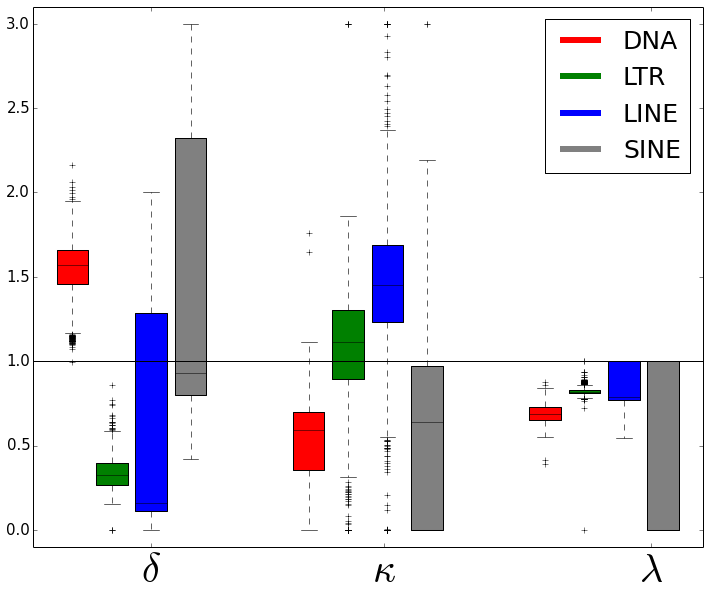

In [41]:
import cloud.serialization.cloudpickle as pickle
pickle_file_name = 'fit_of_TEs_to_tree/no_wtsi_result_dfs.pkl'
output = open(pickle_file_name,'rb')
result_dfs = pickle.pickle.load(output)
output.close()

%matplotlib inline

#colors = plt.cm.Set1(np.linspace(0, 1, len(result_items)))
colors = ('Red' ,'green', 'blue','Gray')
outfile = 'fit_of_TEs_to_tree/bayestraits_boxcompareclasses_no_wtsi.png'
keys = ['DNA','LTR','LINE','SINE']

plot_KDL(keys, result_dfs, colors, outfile)

## 10.7 Compute the medain Kappa Delta and Lambda for each superfamily within each class

In [42]:
#Sort the spuerfamilies according to classes, only retain superfamilies that occur in at least 15 nematode genomes

## Copy and paste elements
## (ie, exclude maverics, helitrons from DNA elements)
cAp = sorted([key for key in result_dfs.keys() if 
                        not 'Unclassified' in key and
                        not '?' in key and not 'averic' in key and not 'elitron' in key and 'DNA/' in key and
                        len([r for r in pj.records if any([key in f.qualifiers.keys() for f in r.features])]) > 14 ],
                       
                       key=lambda n: sum([int(r.features[1].qualifiers[n][0]) for r in pj.records 
                                          if n in r.features[1].qualifiers.keys()]),
                       reverse=True
                       )

ltr = sorted([key for key in result_dfs.keys() if 
                        not 'Unclassified' in key and
                        not '?' in key and 'LTR/' in key and
                        len([r for r in pj.records if any([key in f.qualifiers.keys() for f in r.features])]) > 14 ],
                       
                       key=lambda n: sum([int(r.features[1].qualifiers[n][0]) for r in pj.records 
                                          if n in r.features[1].qualifiers.keys()]),
                       reverse=True
                       )

line = sorted([key for key in result_dfs.keys() if 
                        not 'Unclassified' in key and
                        not '?' in key and 'LINE/' in key and
                        len([r for r in pj.records if any([key in f.qualifiers.keys() for f in r.features])]) > 14 ],
                       
                       key=lambda n: sum([int(r.features[1].qualifiers[n][0]) for r in pj.records 
                                          if n in r.features[1].qualifiers.keys()]),
                       reverse=True
                       )

sine = sorted([key for key in result_dfs.keys() if 
                        not 'Unclassified' in key and
                        not '?' in key and 'SINE/' in key and
                        len([r for r in pj.records if any([key in f.qualifiers.keys() for f in r.features])]) > 14 ],
                       
                       key=lambda n: sum([int(r.features[1].qualifiers[n][0]) for r in pj.records 
                                          if n in r.features[1].qualifiers.keys()]),
                       reverse=True
                       )

## Tyrosine recombinase elements
yr = sorted([key for key in result_dfs.keys() if 
                        not 'Unclassified' in key and
                        not '?' in key and 'YR/' in key and
                        len([r for r in pj.records if any([key in f.qualifiers.keys() for f in r.features])]) > 14 ],
                       
                       key=lambda n: sum([int(r.features[1].qualifiers[n][0]) for r in pj.records 
                                          if n in r.features[1].qualifiers.keys()]),
                       reverse=True
                       )


# Get median values for each superfamily
## (For each superfamily the Kappa, Delta and Lambda are computed multiple times, once for each tree in the tree subset.
## Here I collect the median for each superfamily)
medians_of_resolved_families = {'DNA':{'Kappa':[],'Delta':[],'Lambda':[]},
                                'LTR':{'Kappa':[],'Delta':[],'Lambda':[]},
                                'LINE':{'Kappa':[],'Delta':[],'Lambda':[]},
                                'SINE':{'Kappa':[],'Delta':[],'Lambda':[]},
                                }

 
quartile_cutoffs = {'Kappa':0.5,
                    'Delta':0.5,
                    'Lambda':0.2,
                    }

for clas, fam in [['DNA',cAp],['LTR',ltr],['LINE',line],['SINE',sine]]:
    for f in fam:
        for param in ['Kappa','Delta','Lambda']:
            param_list = result_dfs[f][param].tolist()
            if np.percentile(param_list,75)-np.percentile(param_list,25) < quartile_cutoffs[param]:
                medians_of_resolved_families[clas][param].append(np.median(param_list))

## 10.8 Plot the distribution of medians for each class

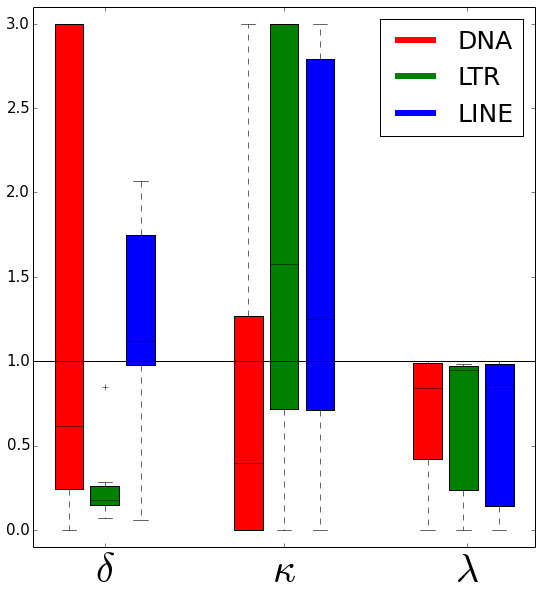

In [43]:
colors = ('Red' ,'green', 'blue')
outfile = 'fit_of_TEs_to_tree/bayestraits_boxcompare_fam_medians_no_wtsi.png'
keys = ['DNA','LTR','LINE']
plot_KDL(keys, medians_of_resolved_families ,colors, outfile, stats='KDL')

## 10.9 A function for drawing the distribution of one transformation for all the classes and superfamilies

In [12]:
# function for setting the colors of the box plots pairs
def set_box_i(bp, index, color):
    setp(bp['boxes'][index], color='black',lw=3)
    setp(bp['caps'][index*2], color='black',lw=3)
    setp(bp['caps'][index*2+1], color='black',lw=3)
    setp(bp['whiskers'][index*2], color='black',lw=3)
    setp(bp['whiskers'][index*2+1], color='black',lw=3)
    setp(bp['fliers'][index*2], color='black',lw=3)
    setp(bp['fliers'][index*2+1], color='black',lw=3)
    setp(bp['medians'][index], color='black',lw=3)
    bp['boxes'][index].set_facecolor(color)

def setBoxColors(bp, colors):
    for index in range(len(colors)):
        set_box_i(bp, index, colors[index])
%matplotlib inline        
def plot_single_param(keys, result_dfs ,colors, outfile, stat, line_data=None):
    if not len(colors) == len(keys):
        raise IOError('need same number of keys and colors')
    # data to plot
    PARAM = [result_dfs[d][stat] for d in keys]
    
    Max = []
    
    Max += [max(i) for i in PARAM]
    
    Max = max(Max)
    
    fig = figure(figsize=[len(keys)*0.3*2*0.8,10])
    ax = axes()
    hold(True)
    
    startpos = 0
    labels = keys
    xticks = range(len(keys))

    bp = boxplot(PARAM, positions = range(startpos, startpos+len(PARAM)), widths = 0.4, patch_artist=True)
    setBoxColors(bp, colors)
    startpos += 1+ len(PARAM)

    
    # set axes limits and labels
    legend_w=0
    xlength=len(keys)+legend_w
    xlim(-1,xlength)
    line, = plot([-1, xlength], [1,1], 'black' ,lw=1)
    ylim(-0.03,Max+0.03)
    
    
    
    ax.set_xticklabels(labels, fontsize=20, rotation=90)
    ax.set_xticks(xticks)
    ax.set_ylabel(r'$\%s$'%stat.lower(), fontsize=40)
    
    if line_data:
        a = plt.gca()
        ax2 = a.twinx()
        plot(line_data, 'black' ,lw=1)
    plt.gcf().subplots_adjust(bottom=0.3)
    savefig(outfile, dpi=900)
    show()

## 10.10 Plot the distributions of each transformation for each clasee and superfamily

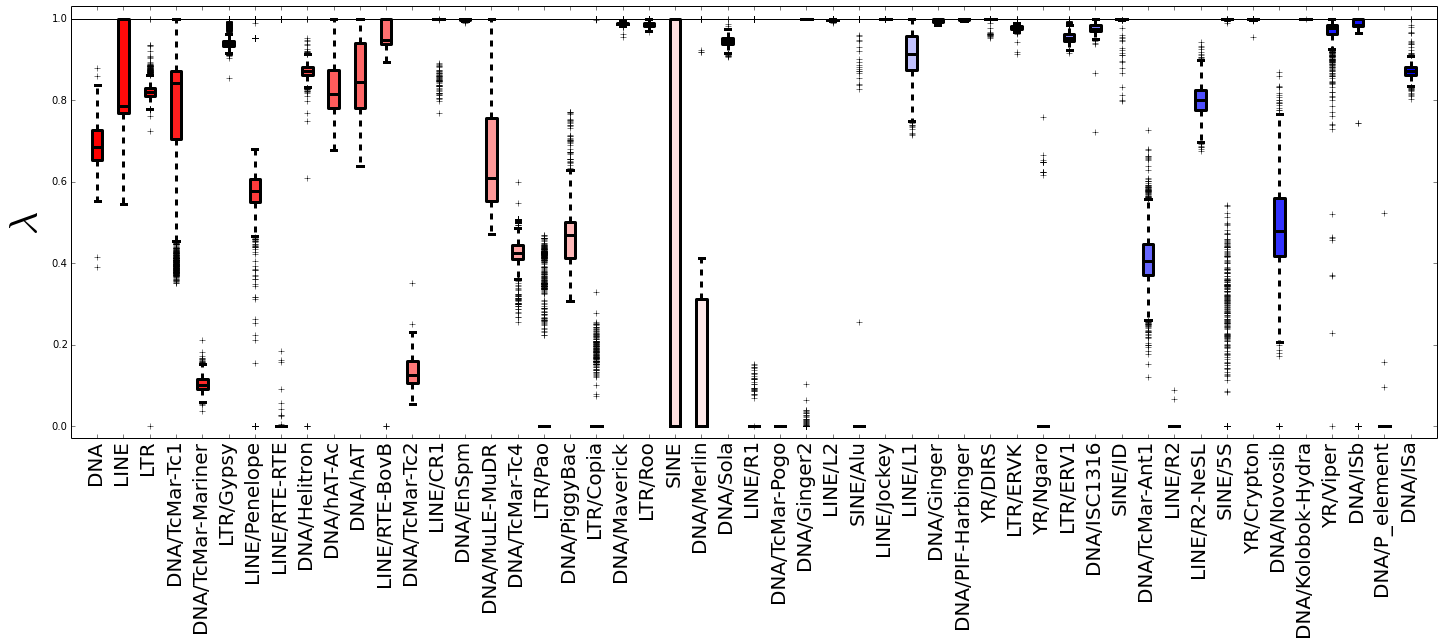

In [13]:
colors = plt.cm.bwr(np.linspace(0, 1, len(TEs)))
outfile = 'fit_of_TEs_to_tree/bayestraits_boxcompare_%s_no_wtsi.png'
plot_single_param(TEs, result_dfs, colors[::-1], outfile%'Lambda', 'Lambda')

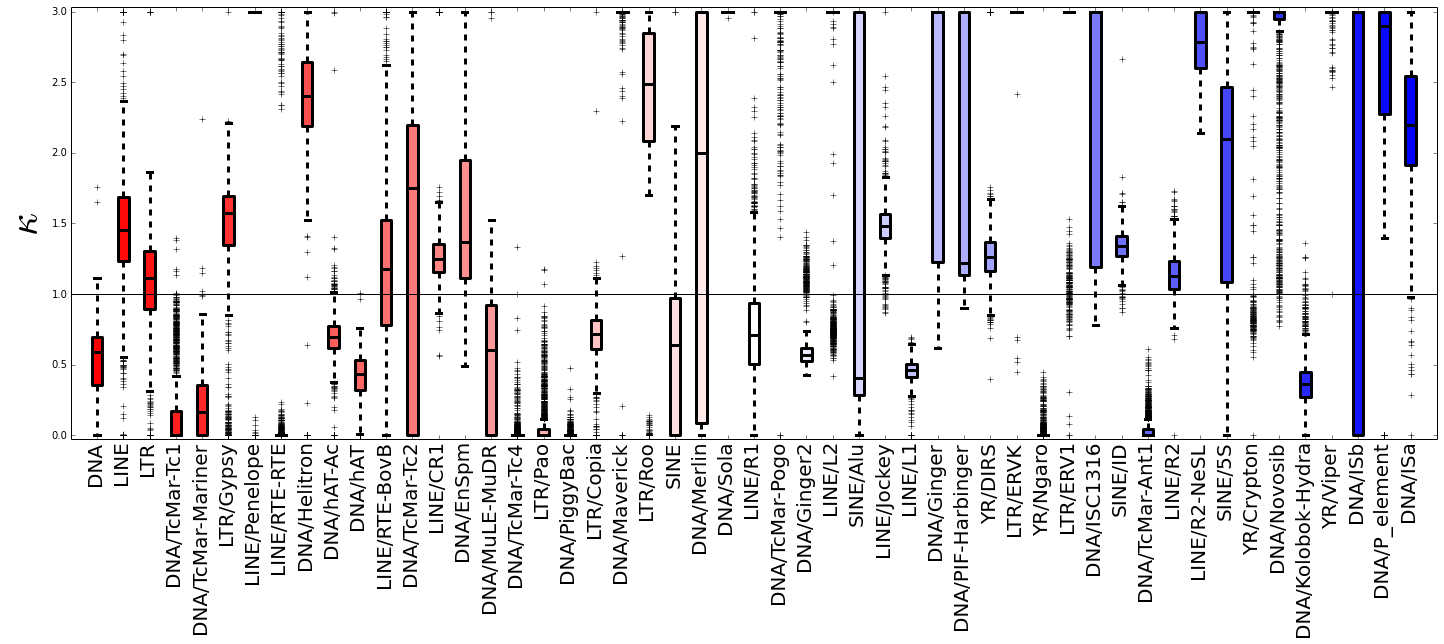

In [14]:
plot_single_param(TEs, result_dfs, colors[::-1], outfile%'Kappa', 'Kappa')

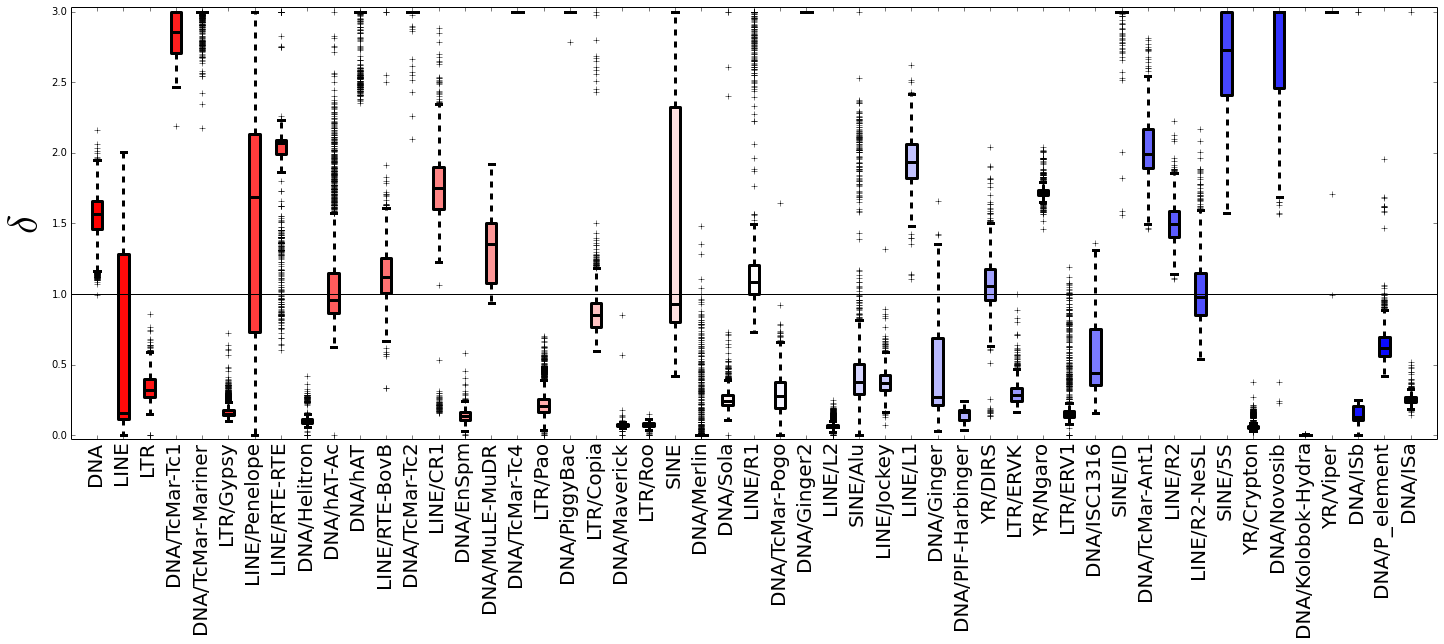

In [15]:
plot_single_param(TEs, result_dfs, colors[::-1], outfile%'Delta', 'Delta')

## 10.11 Make a chain file with ultrametric trees without leaves of unpublished species genomes
The file is `./18S_tree/phylobayes/wo_wtsi.1.treelist.ultras`

In [22]:
# Make a posterior distribution of ULTRAMETRIC trees without WTSI genomes
ultra_trees_wo_wtsi = open('./18S_tree/phylobayes/wo_wtsi.1.treelist.ultras','wt')
hduj_id = pj.ft('18S@SINA@gappyout@dna_cat_gtr').search_nodes(keep="Hduj")[0].name
with open('./18S_tree/phylobayes/wo_wtsi.1.treelist','r') as trees:
    for t in trees:
        T = Tree(t)
        T.set_outgroup(hduj_id)
        T.convert_to_ultrametric(1)
        T.dist=0
        ultra_trees_wo_wtsi.write('%s\n'%T.write(format=5))
ultra_trees_wo_wtsi.close()

returning tree object 18S@SINA@gappyout@dna_cat_gtr


## 10.12 Test for OU process for each superfamily

### Run PMC to predict power to detect OU process

In [3]:
%load_ext rmagic

/usr/local/lib/python2.7/dist-packages/IPython/extensions/rmagic.py:693: UserWarning: The rmagic extension in IPython is deprecated in favour of rpy2.ipython. If available, that will be loaded instead.
http://rpy.sourceforge.net/
  warnings.warn("The rmagic extension in IPython is deprecated in favour of "


In [82]:
%%R

require(pmc)
require(TreeSim)
require(ouch)
library(snow)

nboot <- 1000
alpha <- c(1, 2, 5, 10, 20)
lambda <- c(0.6, 0.8, 1)
cpu <- 6
tree <-read.tree('independent_contrasts/no_wtsi_input.tre')
shape <- lapply(1:length(lambda), function(i){
    simtree <- lambdaTree(tree, lambda[i])
    treepower(ape2ouch(simtree), nboot = nboot, cpu=cpu, alpha = alpha)
})

/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: pmc

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: ggplot2

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘pmc’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:phytools’:

    paintBranches


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: TreeSim

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/f

R Version:  R version 3.2.2 (2015-08-14) 

Library pmc loaded.
Library pmc loaded.
Library pmc loaded.


### Plot power results

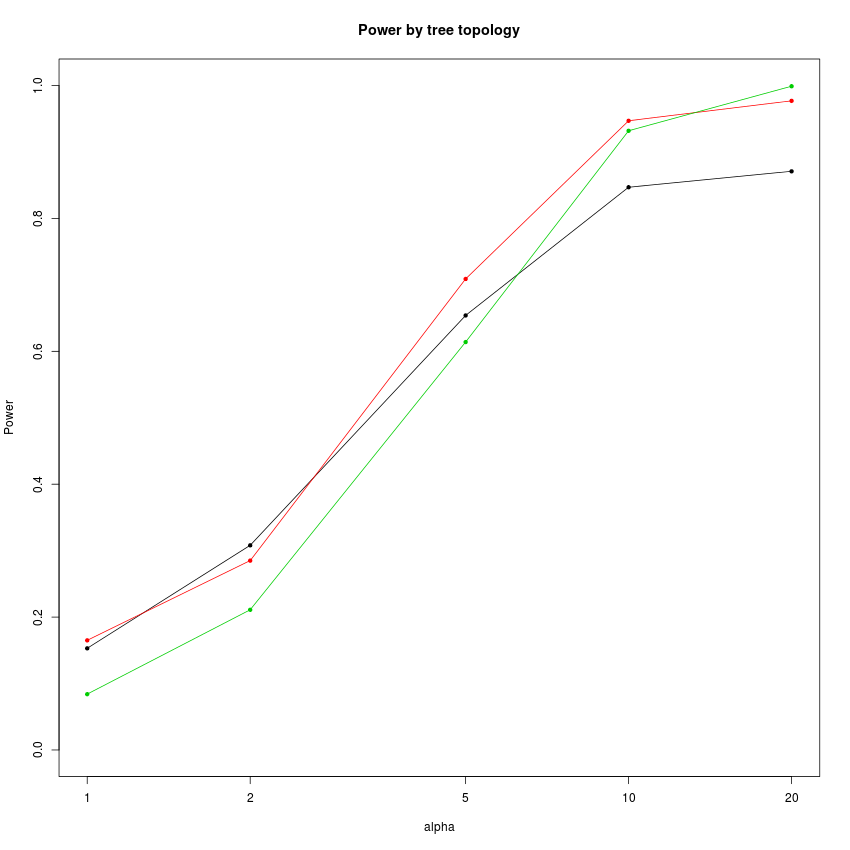

In [83]:
%%R  -w 30 -h 30 -u cm

plot_shape <- function(){
    plot(1, 1, type = "n", xlim = c(min(alpha), max(alpha)),
         ylim = c(0, 1), main = "Power by tree topology",
         log = "x", xlab = "alpha", ylab = "Power")
    k <- length(lambda)
    for (i in 1:k) {
        points(alpha, shape[[i]]$power, pch = 20, col = i)
        lines(alpha, shape[[i]]$power, col = i)
    }
    #legend("topleft", paste(lambda, "lambda"), col = 1:k, pch = 16)
}
plot_shape()    

### Conpute the OT alpha

In [23]:
ultras = './18S_tree/phylobayes/wo_wtsi.1.treelist.ultras'

results = {}

for e in TEs:
    print e
    time.sleep(3)
    
    results[e] = bayestraits(pj, [e],
                             'keep', 'Alyr',
                             bayestraits = 'BayesTraitsV2',
                             treefile = ultras,
                             treeburnin=0.2, treestep=10,
                             commands=[4, 1, 'OU', 'run'])
    hndl = open('model_testing/%s_no_wtsi'%(e.replace('/','_')),'wt')
    hndl.write(results[e])
    hndl.close()

result_dfs = {}

for e in results:
    per_e_results = "Tree No\tLh" + results[e].split("Tree No\tLh")[1]
    table = pd.read_table(StringIO(per_e_results))
    table = table.ix[:,'OU']
    result_dfs[e] = table
    
import cloud.serialization.cloudpickle as pickle
pickle_file_name = 'model_testing/no_wtsi_ou_result_dfs.pkl'
output = open(pickle_file_name,'wb')
pickle.dump(result_dfs, output)
output.close()

DNA
LINE
LTR
DNA/TcMar-Tc1
DNA/TcMar-Mariner
LTR/Gypsy
LINE/Penelope
LINE/RTE-RTE
DNA/Helitron
DNA/hAT-Ac
DNA/hAT
LINE/RTE-BovB
DNA/TcMar-Tc2
LINE/CR1
DNA/EnSpm
DNA/MuLE-MuDR
DNA/TcMar-Tc4
LTR/Pao
DNA/PiggyBac
LTR/Copia
DNA/Maverick
LTR/Roo
SINE
DNA/Merlin
DNA/Sola
LINE/R1
DNA/TcMar-Pogo
DNA/Ginger2
LINE/L2
SINE/Alu
LINE/Jockey
LINE/L1
DNA/Ginger
DNA/PIF-Harbinger
YR/DIRS
LTR/ERVK
YR/Ngaro
LTR/ERV1
DNA/ISC1316
SINE/ID
DNA/TcMar-Ant1
LINE/R2
LINE/R2-NeSL
SINE/5S
YR/Crypton
DNA/Novosib
DNA/Kolobok-Hydra
YR/Viper
DNA/ISb
DNA/P_element
DNA/ISa


## 10.13 Keep values only for superfamilies that occur in at least 15 genomes

In [24]:
TEs = sorted([key for key in result_dfs.keys() if
              not 'Unclassified' in key and
              not '?' in key and
              len([r for r in pj.records if any([key in f.qualifiers.keys() for f in r.features])]) > 14 ],
             
             key=lambda n: sum([int(r.features[1].qualifiers[n][0]) for r in pj.records 
                                          if n in r.features[1].qualifiers.keys()]),
             reverse=True
             )  
TE_quantities = {}
for e in TEs:
    TE_quantities[e] = sum([int(r.features[1].qualifiers[e][0]) for r in pj.records 
                            if e in r.features[1].qualifiers.keys()])

## 10.14 A function to plot the distribution of one paramter for each superfamily

In [25]:
# function for setting the colors of the box plots pairs
def set_box(bp, index, color):
    setp(bp['boxes'][index], color='black',lw=3)
    setp(bp['caps'][index*2], color='black',lw=3)
    setp(bp['caps'][index*2+1], color='black',lw=3)
    setp(bp['whiskers'][index*2], color='black',lw=3)
    setp(bp['whiskers'][index*2+1], color='black',lw=3)
    setp(bp['fliers'][index*2], color='black',lw=3)
    setp(bp['fliers'][index*2+1], color='black',lw=3)
    setp(bp['medians'][index], color='black',lw=3)
    bp['boxes'][index].set_facecolor(color)

def setBoxColors(bp, colors):
    for index in range(len(colors)):
        set_box(bp, index, colors[index])
        
def plot_OU(keys, result_dfs ,colors, outfile, stats='O', line_data = None):
    if not len(colors) == len(keys):
        raise IOError('need same number of keys and colors')
    # data to plot
    OU = [result_dfs[d].tolist() for d in keys]
    
    Max = []
    
    if 'O' in stats:
        Max += [max(i) for i in OU]
    
    Max = max(Max)
    
    fig = figure(figsize=[len(keys)*0.4*2*len(stats)*0.8,20])
    ax = axes()
    hold(True)
    
    startpos = 0
    labels = keys
    xticks = range(len(keys))
    #if len(stats) > 1:
    #    xticks.append(0.15+len(keys)*1.5)
    #if len(stats) > 2:
    #    xticks.append(0.3+len(keys)*2.5)
    
    if 'O' in stats:
        bp = boxplot(OU, positions = range(startpos, startpos+len(OU)), widths = 0.4, patch_artist=True)
        setBoxColors(bp, colors)
        startpos += 1+ len(OU)
        #labels.append('OU')

    
    # set axes limits and labels
    legend_w=0
    xlength=len(stats)*len(keys)+len(stats)+legend_w
    xlim(-1,xlength)
    #line, = plot([-1,xlength], [1,1], 'black' ,lw=1)
    ylim(-0.1,Max+0.1)
    
    
    ax.set_xticklabels(labels, fontsize=20, rotation=90)
    ax.set_xticks(xticks)
    ax.set_ylabel(r'$\alpha$', fontsize=40)

    # draw temporary lines and use them to create a legend
    #Legend = []
    #for c in colors:
    #    L, = plot([1,1],color=c,lw=6)
    #    Legend.append(L)
    #        
    #legend(Legend,keys)
    #for L in Legend:
    #    L.set_visible(False)
    if line_data:
        a = plt.gca()
        ax2 = a.twinx()
        plot(line_data, 'black' ,lw=1)
    
    savefig(outfile, dpi=900)
    show()

## 10.15 Plot the distribution of Alpha accross trees for each superfamily

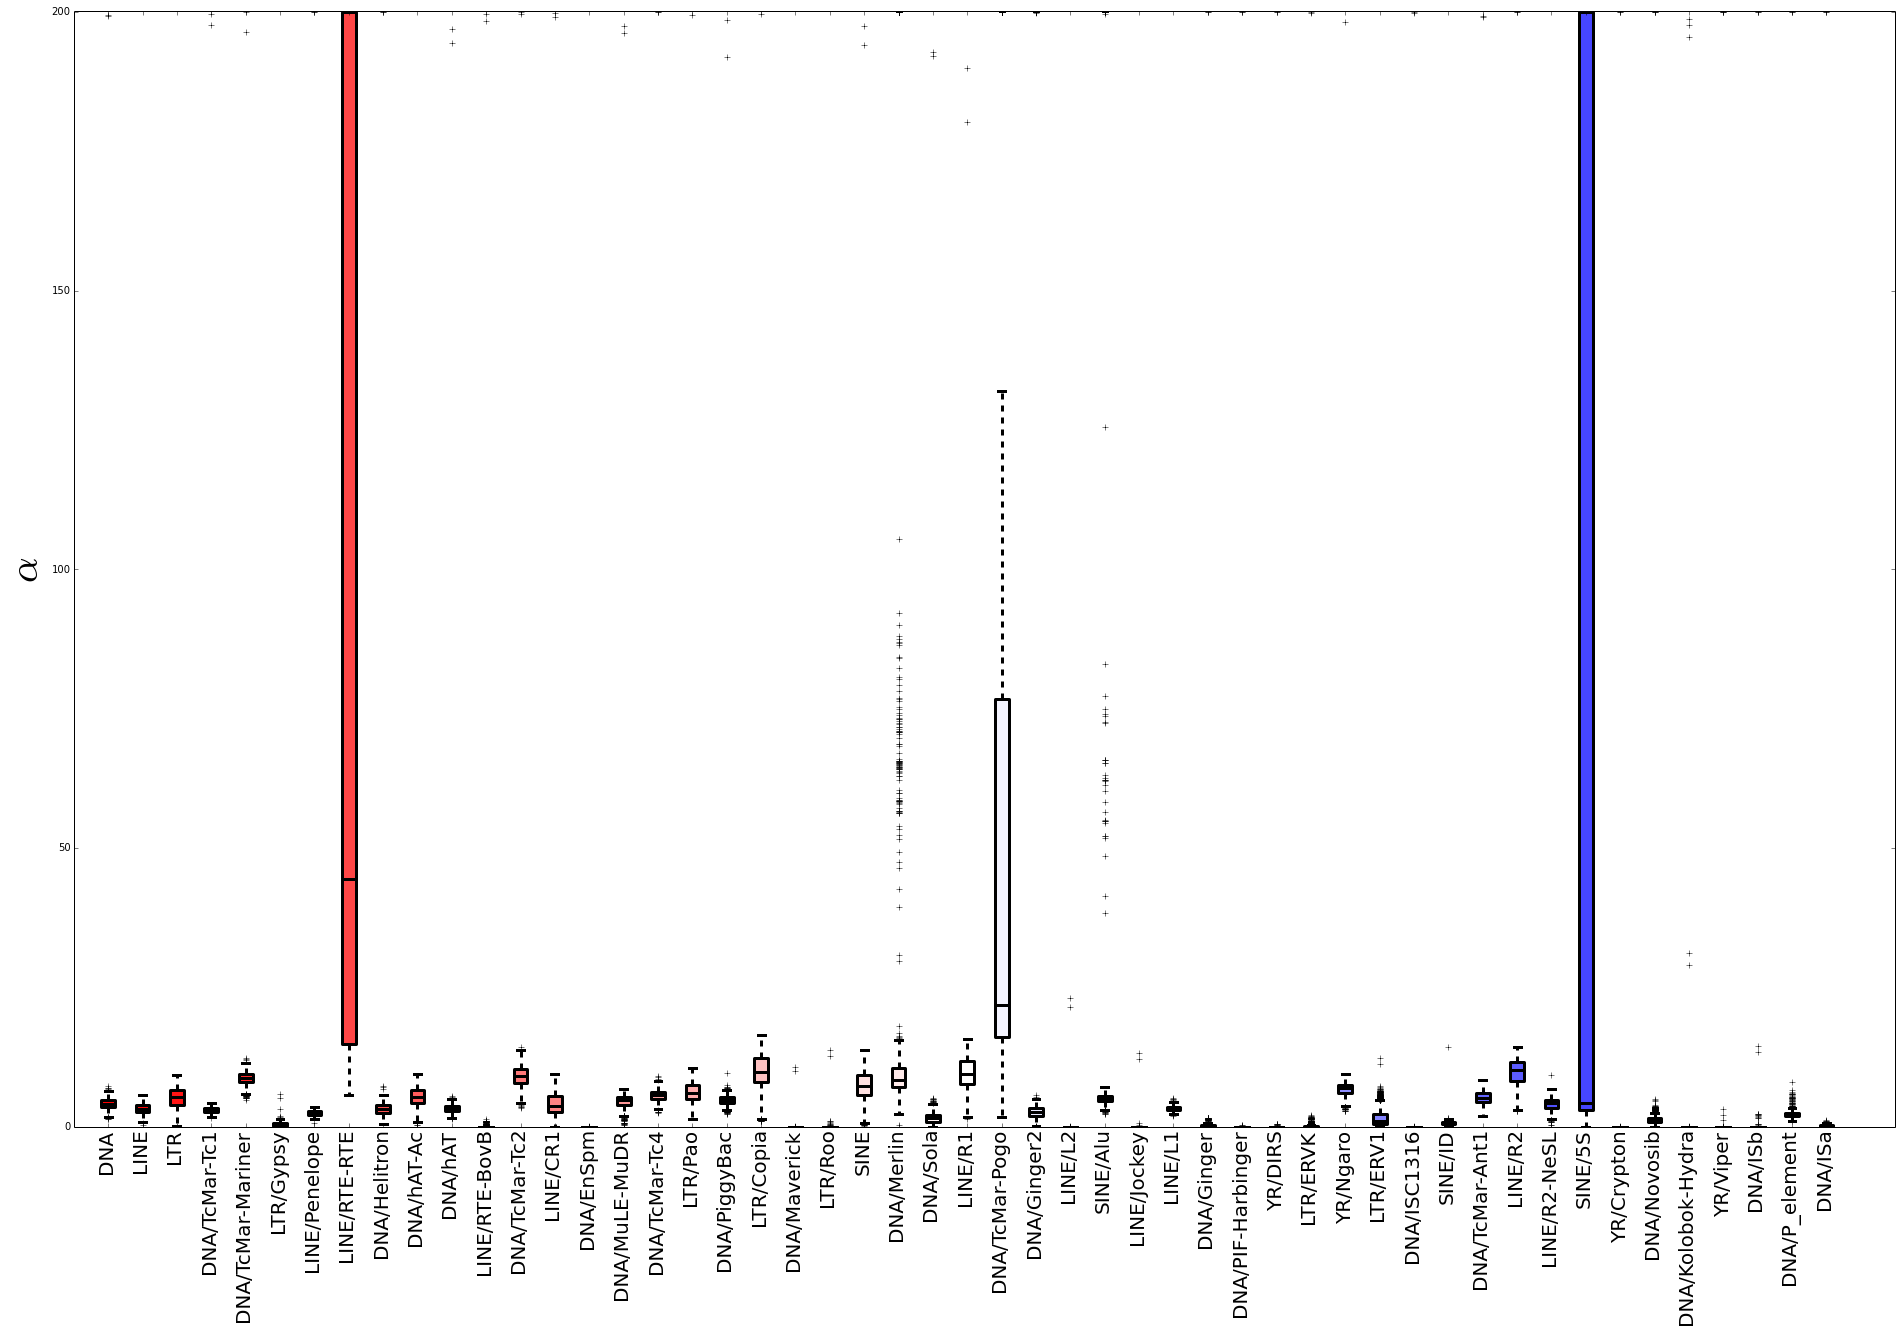

In [26]:
%matplotlib inline
colors = plt.cm.bwr(np.linspace(0, 1, len(TEs)))
outfile = 'model_testing/no_wtsi_OU_%s.png'
plot_OU(TEs, result_dfs ,colors[::-1], outfile, stats='O')

## 10.16 Ultrametric trees with species codes as leaf names
`independent_contrasts/input.tre` is the phylobayes tree with the species codes as leaf names, instead of feature ids.  
`'model_testing/no_wtsi_input.tre.ultra'` is an ultrametric version of this tree.

In [3]:
from reprophylo import *
t = Tree('independent_contrasts/input.tre', format=5)
for n in ['Acan', 'Asim', 'Bpah', 'Btim', 'Ever', 'Sbat', 'Tcan']:
    (t&n).delete()
    
t.convert_to_ultrametric(1)
    
t.write(outfile='model_testing/no_wtsi_input.tre.ultra', format=5)

## 10.17 A function to make a pandas dataframe out of a selection of feature qualifiers in a reprophylo project

In [6]:
def make_df_from_project(pj, meta, meta_values, other_values, outfile=None, sep=",", head=True):
    
    """
    Given a ReproPhylo Project object, this will
    create a pandas df in which the samples (rows)
    are ones that have a value from meta_values
    in the meta qualifier, and the qualifiers from 
    other_values as columns
    """
    
    from itertools import chain
    import pandas as pd
    import csv
    
    csv_lines =[]
    if head:
        csv_lines.append(['sample']+other_values)
    for code in meta_values:
        line = [code]
        f_ids = []
        for f in chain(*[r.features for r in pj.records]):
            if meta in f.qualifiers.keys() and f.qualifiers[meta][0] == code:
                f_ids.append(f.qualifiers['feature_id'][0])
        if len(f_ids) > 1:
            raise RuntimeError("%s is not unique. Needs to apply to one feature"%code)
        elif len(f_ids) == 0:
            raise RuntimeError("%s was not found in any feature"%code)
        quals = get_qualifiers_dictionary(pj, f_ids[0])
        for v in other_values:
            if v in quals.keys():
                checked_value = None
                try:
                    checked_value = float(type_to_single_line_str(quals[v]))
                except:
                    checked_value = type_to_single_line_str(quals[v])
                line.append(checked_value)
            else:
                line.append(0)
                warnings.warn('key %s was not found in sample %s'%(v,code))
        csv_lines.append(line)
    
    if outfile:
        with open(outfile, 'wb') as csvfile:
            csvwriter = csv.writer(csvfile, delimiter=sep,
                                    quotechar='|', quoting=csv.QUOTE_MINIMAL)
            for l in csv_lines:
                csvwriter.writerow(l)
    header = csv_lines.pop(0)
    return pd.DataFrame(csv_lines, columns=header)

## 10.18 Make a list of species to include the surface analysis, and a list of superfamilies to include.
The species are ones with a published genome. The superfamilies are ones that occur in at least 15 species and that have a significant alpha (OU process).

In [3]:
%load_ext rmagic
import TE

# Make a list of species to analyse
expected_codes = TE.genome_codes_list('Genomes/',code_file='genome_assembly_files_v3.csv')

if len(expected_codes) == 0:
    raise IOError('could not read expected codes')
        
for code in ['Eela','Ooch','Acan', 'Asim', 'Bpah', 'Btim', 'Ever', 'Sbat', 'Tcan']:
    try:
        expected_codes.remove(code)
    except:
        print "%s not in list"%code

# Make a list of classes and superfamilies to analyse
import cloud.serialization.cloudpickle as pickle
from reprophylo import *
import TE
pickle_file_name = 'model_testing/no_wtsi_ou_result_dfs.pkl'
pickle_handle = open(pickle_file_name, 'rb')
result_dfs = pickle.pickle.load(pickle_handle)
pj = unpickle_pj('independent_contrasts/18S_tree_reprophylo_project_with_TE_style_and_RNAi', git=False)


import numpy as np        
TEs = sorted([key for key in result_dfs.keys() if
              not 'Unclassified' in key and
              not '?' in key and not key in ['DNA','LTR','LINE','SINE'] and
              len([r for r in pj.records if any([key in f.qualifiers.keys() for f in r.features])]) > 14 and
              # alpha is significantly different than 0
              np.percentile(result_dfs[key].tolist(),5) > 1
             ],
             
             key=lambda n: sum([int(r.features[1].qualifiers[n][0]) for r in pj.records 
                                          if n in r.features[1].qualifiers.keys()]),
             reverse=True
             )  
TEs

The rmagic extension is already loaded. To reload it, use:
  %reload_ext rmagic


['DNA/TcMar-Tc1',
 'DNA/TcMar-Mariner',
 'LINE/Penelope',
 'LINE/RTE-RTE',
 'DNA/Helitron',
 'DNA/hAT-Ac',
 'DNA/hAT',
 'DNA/TcMar-Tc2',
 'LINE/CR1',
 'DNA/MuLE-MuDR',
 'DNA/TcMar-Tc4',
 'LTR/Pao',
 'DNA/PiggyBac',
 'LTR/Copia',
 'DNA/Merlin',
 'LINE/R1',
 'DNA/TcMar-Pogo',
 'DNA/Ginger2',
 'SINE/Alu',
 'LINE/L1',
 'YR/Ngaro',
 'DNA/TcMar-Ant1',
 'LINE/R2',
 'LINE/R2-NeSL',
 'DNA/P_element']

## 10.19 Fit an OU model with a stochastic component to TEs with an OU process.

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc1 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc1 was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc1 was not found in sample Haor
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc1 was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc1 was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc1 was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc1 was not found in sample Pcof


$n_steps
[1] 2

$lnls
                   [,1]      [,2]
DNA.TcMar.Tc1 -314.0624 -316.9418

$n_regimes_seq
               [,1] [,2]
k                 8    8
kprime            8    6
deltak            0    2
c                 0    3
kprime_conv       0    1
kprime_nonconv    8    5

$aics
       1        2 
692.6247 686.8067 

$shifts
  1  16  21  66  63  60  58   5 
"a" "b" "c" "d" "d" "d" "g" "h" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
             8              6              2              3              1 
kprime_nonconv 
             5 

$alpha
DNA.TcMar.Tc1 
     1132.879 

$phylhalflife
DNA.TcMar.Tc1 
 0.0006118457 

$sigma_squared
DNA.TcMar.Tc1 
    334861513 

$theta
  DNA.TcMar.Tc1
a      196.9091
b    12788.0000
c     2432.0000
d     6094.0000
g     9310.0000
h     1335.0000



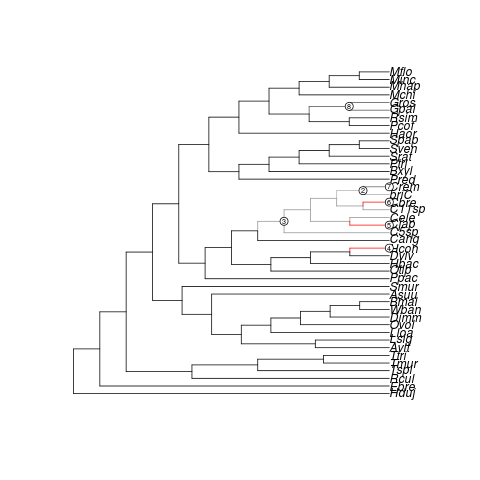

$n_steps
[1] 3

$lnls
                       [,1]      [,2]      [,3]
DNA.TcMar.Mariner -274.2202 -274.7575 -276.4472

$n_regimes_seq
               [,1] [,2] [,3]
k                 8    8    8
kprime            8    7    6
deltak            0    1    2
c                 0    2    3
kprime_conv       0    1    1
kprime_nonconv    8    6    5

$aics
       1        2        3 
612.9403 607.9950 605.8174 

$shifts
  1  66  63  59  52  83  27  56 
"a" "b" "c" "d" "e" "e" "g" "e" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
             8              6              2              3              1 
kprime_nonconv 
             5 

$alpha
DNA.TcMar.Mariner 
         9905.827 

$phylhalflife
DNA.TcMar.Mariner 
     6.997368e-05 

$sigma_squared
DNA.TcMar.Mariner 
        445046718 

$theta
  DNA.TcMar.Mariner
a          84.37037
b        9198.00000
c        3510.00000
d        2412.00000
e         830.33333
g         338.00000



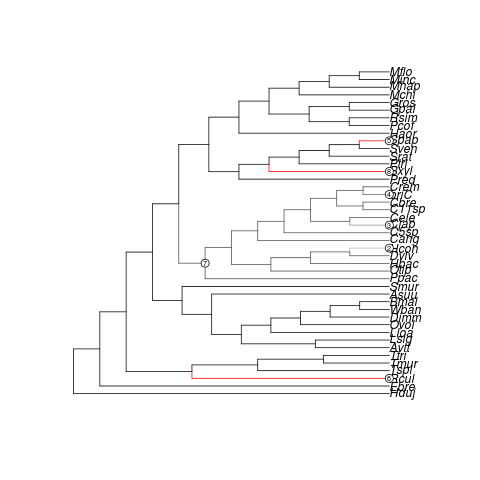

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Penelope was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Penelope was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Penelope was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Penelope was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Penelope was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Penelope was not found in sample Mflo
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Penelope was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LIN

$n_steps
[1] 4

$lnls
              [,1]     [,2]     [,3]    [,4]
LINE.Penelope 3474 3625.086 3690.556 78.4978

$n_regimes_seq
               [,1] [,2] [,3] [,4]
k                18   18   18   18
kprime           18   17   14   13
deltak            0    1    4    5
c                 0    2    6    8
kprime_conv       0    1    2    3
kprime_nonconv   18   16   12   10

$aics
         1          2          3          4 
-6131.0001 -6613.7710 -7015.6116   158.3377 

$shifts
  1  81  66  38  84  70  72  23  83  60  41  65  76  71   4  85   5   6 
"a" "a" "c" "d" "e" "f" "g" "h" "i" "j" "k" "l" "m" "n" "k" "j" "k" "k" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
            18             13              5              8              3 
kprime_nonconv 
            10 

$alpha
LINE.Penelope 
     148756.4 

$phylhalflife
LINE.Penelope 
 4.659611e-06 

$sigma_squared
LINE.Penelope 
     1229.392 

$theta
  LINE.Penelope
a  9.032000e+03
c  3.06400

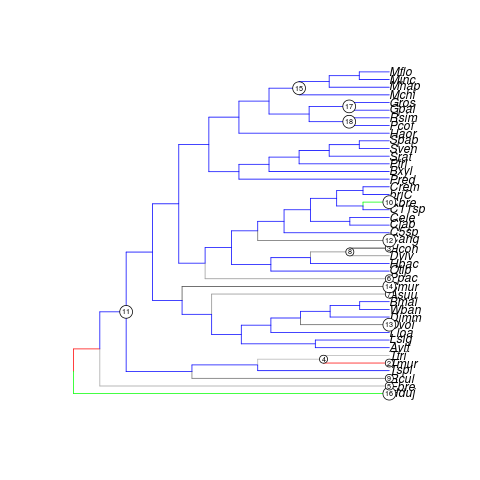

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-RTE was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-RTE was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-RTE was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-RTE was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-RTE was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-RTE was not found in sample Mflo
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-RTE was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-R

$n_steps
[1] 2

$lnls
                [,1]     [,2]
LINE.RTE.RTE 1723.71 1840.996

$n_regimes_seq
               [,1] [,2]
k                17   17
kprime           17   16
deltak            0    1
c                 0    2
kprime_conv       0    1
kprime_nonconv   17   15

$aics
        1         2 
-2931.421 -3251.993 

$shifts
  1  66  72  70  63  23  10  69  60  52  19  64  57  76   5  47   2 
"a" "b" "c" "d" "e" "f" "g" "h" "i" "j" "k" "l" "m" "n" "o" "p" "a" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
            17             16              1              2              1 
kprime_nonconv 
            15 

$alpha
LINE.RTE.RTE 
    26674594 

$phylhalflife
LINE.RTE.RTE 
2.598529e-08 

$sigma_squared
LINE.RTE.RTE 
5.511809e-31 

$theta
  LINE.RTE.RTE
a            0
b         5669
c         1354
d         1282
e          873
f          590
g          131
h          259
i          115
j          274
k           64
l           60
m        

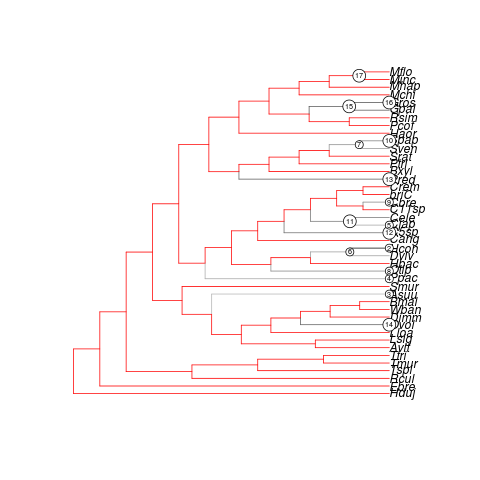

$n_steps
[1] 2

$lnls
                  [,1]      [,2]
DNA.Helitron -308.9573 -313.1946

$n_regimes_seq
               [,1] [,2]
k                 9    9
kprime            9    5
deltak            0    4
c                 0    7
kprime_conv       0    3
kprime_nonconv    9    2

$aics
       1        2 
696.0965 679.3124 

$shifts
  1  83  76  22  41  66  59   2  60 
"a" "b" "c" "d" "e" "a" "c" "d" "a" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
             9              5              4              7              3 
kprime_nonconv 
             2 

$alpha
DNA.Helitron 
    723.8027 

$phylhalflife
DNA.Helitron 
0.0009576466 

$sigma_squared
DNA.Helitron 
   179745436 

$theta
  DNA.Helitron
a    3303.5000
b    6454.0000
c    5214.0000
d    1974.1250
e     161.0357



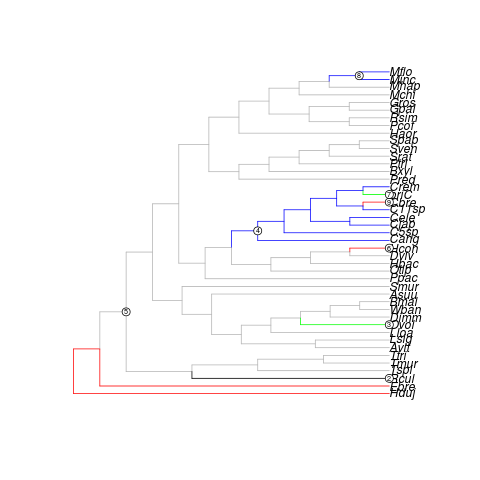

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT-Ac was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT-Ac was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT-Ac was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT-Ac was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT-Ac was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT-Ac was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT-Ac was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT-Ac was not found

$n_steps
[1] 2

$lnls
                [,1]    [,2]
DNA.hAT.Ac -239.6122 -239.88

$n_regimes_seq
               [,1] [,2]
k                 9    9
kprime            9    7
deltak            0    2
c                 0    4
kprime_conv       0    2
kprime_nonconv    9    5

$aics
       1        2 
557.4061 544.2600 

$shifts
  1  63   5   2  84  83  47   4  18 
"a" "b" "c" "d" "c" "d" "g" "h" "i" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
             9              7              2              4              2 
kprime_nonconv 
             5 

$alpha
DNA.hAT.Ac 
    354.43 

$phylhalflife
 DNA.hAT.Ac 
0.001955667 

$sigma_squared
DNA.hAT.Ac 
   2907682 

$theta
  DNA.hAT.Ac
a   34.23333
b 6549.00000
c 5025.00000
d 4081.00000
g 3289.00000
h  501.00000
i  332.25000



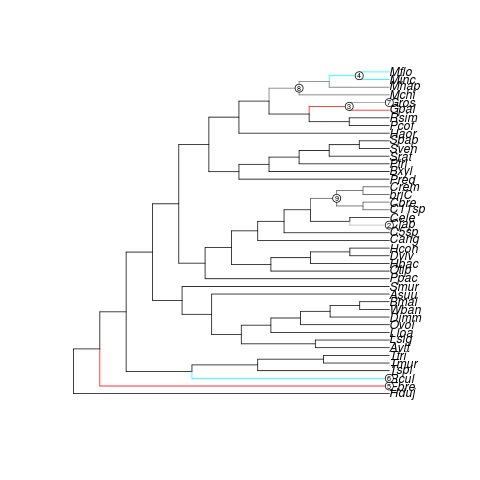

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT was not found in sample Hcon


$n_steps
[1] 2

$lnls
             [,1]      [,2]
DNA.hAT -296.9085 -299.1152

$n_regimes_seq
               [,1] [,2]
k                 7    7
kprime            7    5
deltak            0    2
c                 0    4
kprime_conv       0    2
kprime_nonconv    7    3

$aics
       1        2 
646.7400 641.2303 

$shifts
  1  63  20   5  61   2  58 
"a" "b" "c" "c" "e" "e" "g" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
             7              5              2              4              2 
kprime_nonconv 
             3 

$alpha
 DNA.hAT 
492.3984 

$phylhalflife
    DNA.hAT 
0.001407696 

$sigma_squared
 DNA.hAT 
63525342 

$theta
    DNA.hAT
a  141.0606
b 7868.0000
c 3457.6000
e 1505.3333
g 4391.0000



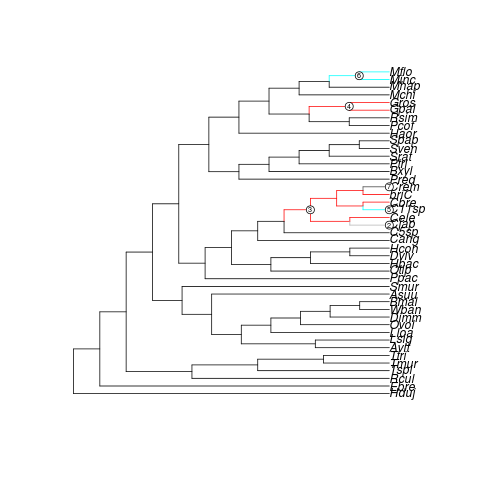

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc2 was not found in sample Hbak
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc2 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc2 was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc2 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc2 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc2 was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc2 was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA

$n_steps
[1] 4

$lnls
                   [,1]      [,2]      [,3]      [,4]
DNA.TcMar.Tc2 -212.0183 -212.0326 -213.8884 -218.1251

$n_regimes_seq
               [,1] [,2] [,3] [,4]
k                12   12   12   12
kprime           12   11    9    8
deltak            0    1    3    4
c                 0    2    5    6
kprime_conv       0    1    2    2
kprime_nonconv   12   10    7    6

$aics
       1        2        3        4 
563.7867 550.5358 531.8820 530.8502 

$shifts
  1  63  59   2   5  18  83  38   3  64  61  80 
"a" "b" "c" "d" "e" "f" "f" "h" "h" "h" "h" "l" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
            12              8              4              6              2 
kprime_nonconv 
             6 

$alpha
DNA.TcMar.Tc2 
     380336.4 

$phylhalflife
DNA.TcMar.Tc2 
 1.822458e-06 

$sigma_squared
DNA.TcMar.Tc2 
   1133085651 

$theta
  DNA.TcMar.Tc2
a      18.17241
b   15694.00000
c   10130.00000
d    1649.50000
e     89

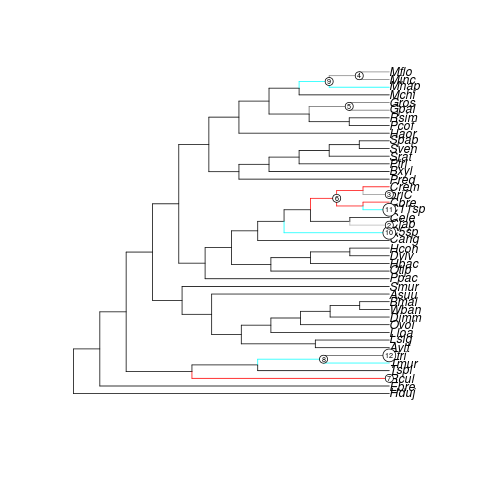

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Bxyl
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Hbac


$n_steps
[1] 2

$lnls
              [,1]      [,2]
LINE.CR1 -179.2986 -192.8323

$n_regimes_seq
               [,1] [,2]
k                12   12
kprime           12    8
deltak            0    4
c                 0    7
kprime_conv       0    3
kprime_nonconv   12    5

$aics
       1        2 
498.3471 480.2646 

$shifts
  1  83  63  66  70  16  84  72  19   2  41  60 
"a" "b" "b" "d" "e" "f" "g" "f" "i" "a" "k" "a" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
            12              8              4              7              3 
kprime_nonconv 
             5 

$alpha
LINE.CR1 
10.77141 

$phylhalflife
  LINE.CR1 
0.06435066 

$sigma_squared
LINE.CR1 
9941.486 

$theta
     LINE.CR1
a  205.573987
b 3783.154444
d 2108.910130
e 1336.468325
f  732.433051
g  906.036079
i  492.279764
k    8.953722



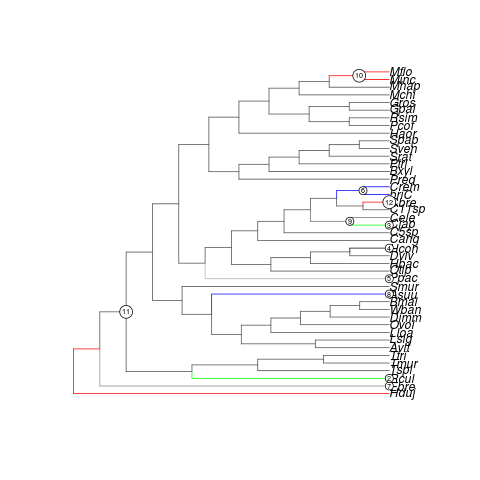

$n_steps
[1] 4

$lnls
                   [,1]      [,2]      [,3]      [,4]
DNA.MuLE.MuDR -272.6547 -272.7896 -273.2404 -273.9693

$n_regimes_seq
               [,1] [,2] [,3] [,4]
k                 9    9    9    9
kprime            9    8    7    6
deltak            0    1    2    3
c                 0    2    4    6
kprime_conv       0    1    2    3
kprime_nonconv    9    7    5    3

$aics
       1        2        3        4 
623.4912 616.6227 610.9809 606.4185 

$shifts
  1  18  61  59  84  19  83  81  22 
"a" "b" "a" "d" "e" "f" "e" "h" "h" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
             9              6              3              6              3 
kprime_nonconv 
             3 

$alpha
DNA.MuLE.MuDR 
     2413.248 

$phylhalflife
DNA.MuLE.MuDR 
 0.0002872258 

$sigma_squared
DNA.MuLE.MuDR 
     96680097 

$theta
  DNA.MuLE.MuDR
a      124.5758
b     4991.0000
d     2933.0000
e     1729.5000
f     1251.5000
h      687.6667


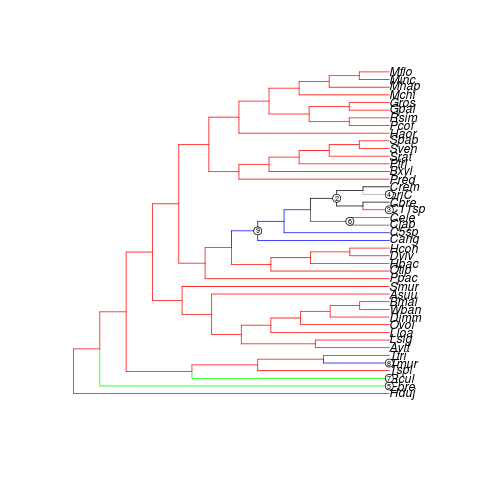

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc4 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc4 was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc4 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc4 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc4 was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc4 was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc4 was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA

$n_steps
[1] 2

$lnls
                   [,1]      [,2]
DNA.TcMar.Tc4 -61.75157 -72.46694

$n_regimes_seq
               [,1] [,2]
k                15   15
kprime           15   12
deltak            0    3
c                 0    5
kprime_conv       0    2
kprime_nonconv   15   10

$aics
       1        2 
398.7031 336.7800 

$shifts
  1  63  58  21  66  61  41  70  42   5  22  46  81  18  16 
"a" "b" "c" "d" "e" "f" "g" "h" "h" "j" "j" "j" "m" "n" "o" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
            15             12              3              5              2 
kprime_nonconv 
            10 

$alpha
DNA.TcMar.Tc4 
     744221.8 

$phylhalflife
DNA.TcMar.Tc4 
 9.313718e-07 

$sigma_squared
DNA.TcMar.Tc4 
      2535737 

$theta
  DNA.TcMar.Tc4
a   141.0000000
b  4013.0000000
c  2951.0000000
d   782.0000000
e   716.0000000
f   304.0000000
g     0.3333333
h   272.5000000
j    70.2500000
m    35.0000000
n   818.0000000
o   800.0000000



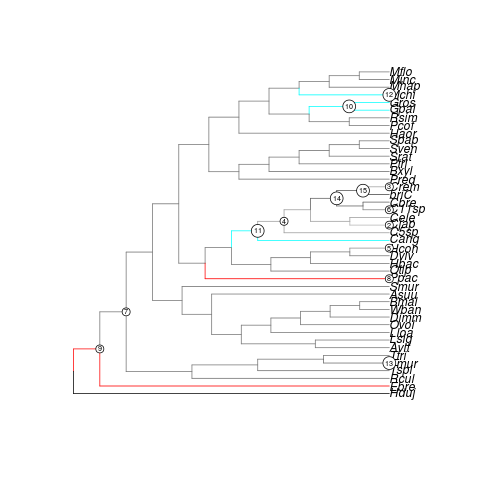

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/Pao was not found in sample Pcof


$n_steps
[1] 2

$lnls
             [,1]      [,2]
LTR.Pao -292.8302 -293.3483

$n_regimes_seq
               [,1] [,2]
k                 4    4
kprime            4    3
deltak            0    1
c                 0    2
kprime_conv       0    1
kprime_nonconv    4    2

$aics
       1        2 
612.5354 610.1511 

$shifts
  1  63  66  58 
"a" "b" "b" "d" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
             4              3              1              2              1 
kprime_nonconv 
             2 

$alpha
  LTR.Pao 
0.8890072 

$phylhalflife
  LTR.Pao 
0.7796868 

$sigma_squared
 LTR.Pao 
162600.5 

$theta
     LTR.Pao
a   298.0411
b 11450.6466
d  5805.4939



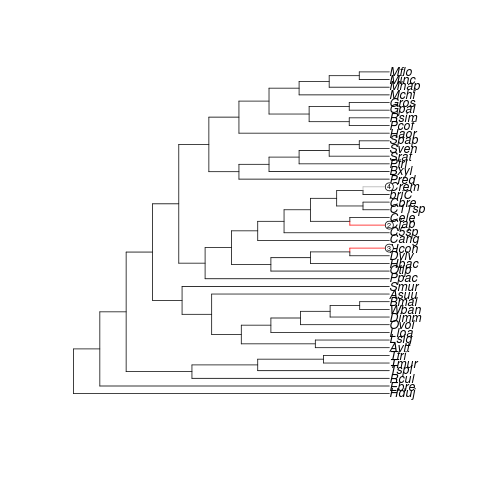

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyBac was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyBac was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyBac was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyBac was not found in sample Asuu
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyBac was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyBac was not found in sample Haor
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyBac was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyB

$n_steps
[1] 3

$lnls
                  [,1]      [,2]      [,3]
DNA.PiggyBac -146.1643 -146.6242 -148.0842

$n_regimes_seq
               [,1] [,2] [,3]
k                13   13   13
kprime           13   12   11
deltak            0    1    2
c                 0    2    4
kprime_conv       0    1    2
kprime_nonconv   13   11    9

$aics
       1        2        3 
464.3286 448.0484 435.9184 

$shifts
  1  21  59  20  62  18  61  82  66  16  84  83  57 
"a" "b" "c" "a" "e" "f" "g" "h" "i" "j" "k" "l" "l" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
            13             11              2              4              2 
kprime_nonconv 
             9 

$alpha
DNA.PiggyBac 
      490453 

$phylhalflife
DNA.PiggyBac 
1.413279e-06 

$sigma_squared
DNA.PiggyBac 
    56290457 

$theta
  DNA.PiggyBac
a        4.125
b     4733.000
c     5655.000
e     3173.000
f     1736.000
g      614.000
h      397.000
i      330.000
j     1437.000
k      217.

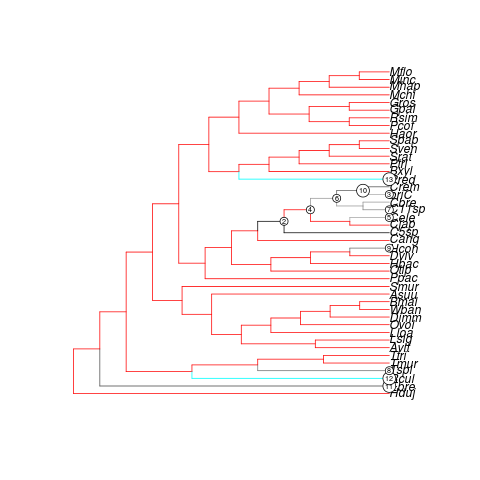

$n_steps
[1] 4

$lnls
               [,1]      [,2]      [,3]      [,4]
LTR.Copia -223.4242 -223.4866 -223.5909 -224.3434

$n_regimes_seq
               [,1] [,2] [,3] [,4]
k                 9    9    9    9
kprime            9    7    6    5
deltak            0    2    3    4
c                 0    4    6    7
kprime_conv       0    2    3    3
kprime_nonconv    9    5    3    2

$aics
       1        2        3        4 
525.0303 511.4733 505.6618 501.6098 

$shifts
  1  63  84  40   2  66  82   5  60 
"a" "b" "c" "d" "d" "d" "a" "h" "h" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
             9              5              4              7              3 
kprime_nonconv 
             2 

$alpha
LTR.Copia 
 3357.308 

$phylhalflife
   LTR.Copia 
0.0002064592 

$sigma_squared
LTR.Copia 
 13367915 

$theta
   LTR.Copia
a   41.59375
b 2647.00000
c  848.00000
d  399.83333
h  230.66667



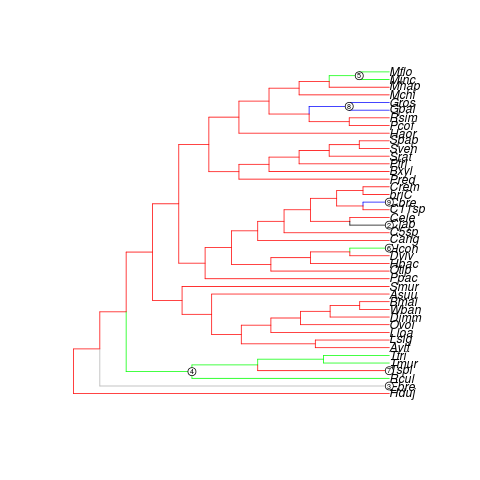

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found in sample Dviv
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found in sample Bxyl
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found

$n_steps
[1] 2

$lnls
                [,1]      [,2]
DNA.Merlin -208.1244 -214.9893

$n_regimes_seq
               [,1] [,2]
k                10   10
kprime           10    5
deltak            0    5
c                 0    8
kprime_conv       0    3
kprime_nonconv   10    2

$aics
       1        2 
510.8488 488.4586 

$shifts
  1  81  60  16  46  63   2   5  83  21 
"a" "b" "b" "d" "d" "f" "f" "f" "f" "j" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
            10              5              5              8              3 
kprime_nonconv 
             2 

$alpha
DNA.Merlin 
  10.95781 

$phylhalflife
DNA.Merlin 
0.06325601 

$sigma_squared
DNA.Merlin 
  28314.65 

$theta
  DNA.Merlin
a   18.29106
b 1623.68806
d  709.99105
f  284.86016
j  112.62972



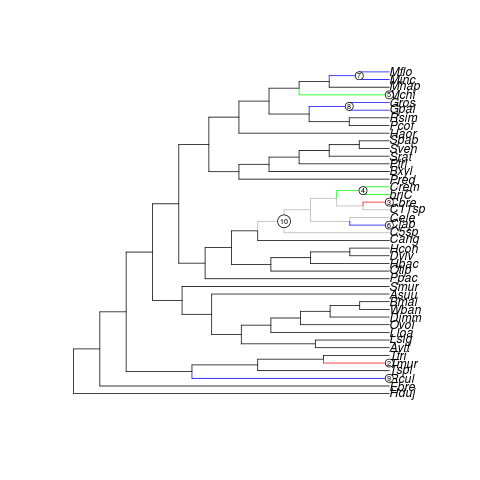

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R1 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R1 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R1 was not found in sample Pcof


$n_steps
[1] 2

$lnls
             [,1]      [,2]
LINE.R1 -120.7579 -124.5817

$n_regimes_seq
               [,1] [,2]
k                 9    9
kprime            9    6
deltak            0    3
c                 0    5
kprime_conv       0    2
kprime_nonconv    9    4

$aics
       1        2 
319.6976 307.6435 

$shifts
  1  63  81  84  51  83  71  66   5 
"a" "b" "c" "d" "d" "f" "g" "g" "g" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
             9              6              3              5              2 
kprime_nonconv 
             4 

$alpha
 LINE.R1 
111246.6 

$phylhalflife
     LINE.R1 
6.230725e-06 

$sigma_squared
LINE.R1 
4278008 

$theta
      LINE.R1
a    5.352941
b 2184.000000
c  866.000000
d  466.500000
f  423.000000
g   23.750000



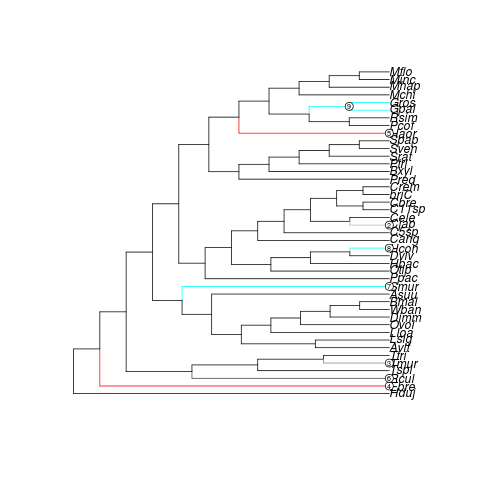

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Pogo was not found in sample Hbak
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Pogo was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Pogo was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Pogo was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Pogo was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Pogo was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Pogo was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: 

$n_steps
[1] 2

$lnls
                   [,1]     [,2]
DNA.TcMar.Pogo 1458.813 1266.724

$n_regimes_seq
               [,1] [,2]
k                16   16
kprime           16   15
deltak            0    1
c                 0    2
kprime_conv       0    1
kprime_nonconv   16   14

$aics
        1         2 
-2552.126 -2218.115 

$shifts
  1  62  80   2   5  38  47  61  19  43   4  50  64  59   3  37 
"a" "b" "c" "d" "e" "f" "g" "h" "i" "j" "k" "l" "m" "n" "o" "a" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
            16             15              1              2              1 
kprime_nonconv 
            14 

$alpha
DNA.TcMar.Pogo 
       1695401 

$phylhalflife
DNA.TcMar.Pogo 
  4.088396e-07 

$sigma_squared
DNA.TcMar.Pogo 
   1.00186e-20 

$theta
  DNA.TcMar.Pogo
a              0
b            962
c            847
d            572
e            304
f            207
g            422
h             52
i             28
j            607
k      

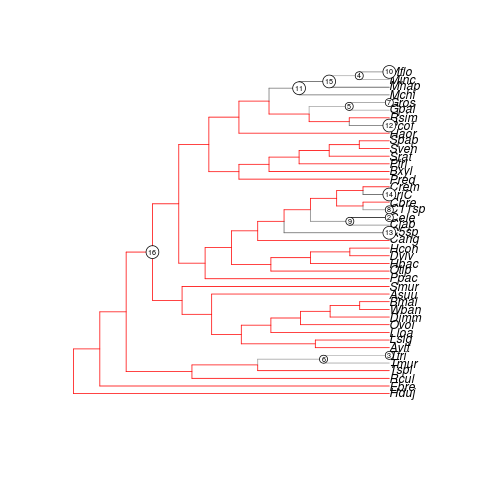

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was not found in sample Hbak
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was not found in sample Dviv
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was n

$n_steps
[1] 4

$lnls
                [,1]    [,2]     [,3]     [,4]
DNA.Ginger2 3189.378 3247.18 3251.279 3251.279

$n_regimes_seq
               [,1] [,2] [,3] [,4]
k                18   18   18   18
kprime           18   17   16   14
deltak            0    1    2    4
c                 0    2    4    6
kprime_conv       0    1    2    2
kprime_nonconv   18   16   14   12

$aics
        1         2         3         4 
-5561.756 -5857.961 -5986.558 -6137.058 

$shifts
  1  56   2  10  82  43  64   4  52   3  76   6  42  53  49  11  26  12 
"a" "b" "c" "a" "e" "f" "g" "h" "i" "j" "k" "l" "m" "n" "o" "m" "m" "m" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
            18             14              4              6              2 
kprime_nonconv 
            12 

$alpha
DNA.Ginger2 
   346330.5 

$phylhalflife
 DNA.Ginger2 
2.001404e-06 

$sigma_squared
DNA.Ginger2 
2.32993e-61 

$theta
  DNA.Ginger2
a           0
b        1594
c         649


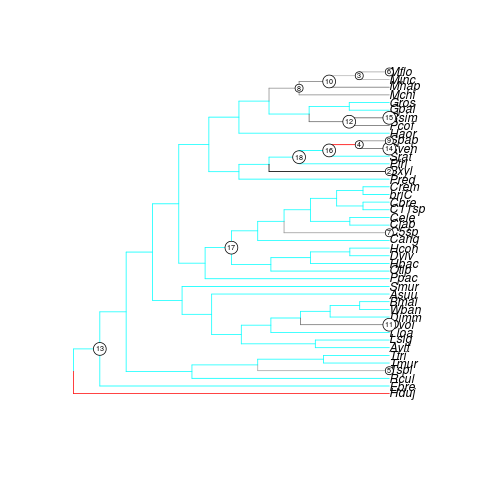

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Mflo


$n_steps
[1] 2

$lnls
              [,1]      [,2]
SINE.Alu -84.12374 -85.47427

$n_regimes_seq
               [,1] [,2]
k                 7    7
kprime            7    6
deltak            0    1
c                 0    2
kprime_conv       0    1
kprime_nonconv    7    5

$aics
       1        2 
221.1706 218.7263 

$shifts
  1  23   5  70  73  60  63 
"a" "b" "c" "b" "e" "f" "g" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
             7              6              1              2              1 
kprime_nonconv 
             5 

$alpha
SINE.Alu 
4060.136 

$phylhalflife
    SINE.Alu 
0.0001707202 

$sigma_squared
SINE.Alu 
25362.13 

$theta
   SINE.Alu
a  1.171429
b 68.333333
c 54.500000
e 60.000000
f 33.000000
g 14.000000



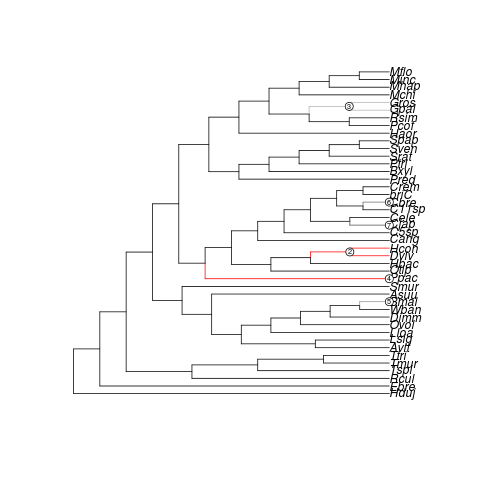

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Dviv
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Cele
/usr/loc

$n_steps
[1] 2

$lnls
             [,1]      [,2]
LINE.L1 -132.3414 -136.2115

$n_regimes_seq
               [,1] [,2]
k                10   10
kprime           10    7
deltak            0    3
c                 0    5
kprime_conv       0    2
kprime_nonconv   10    5

$aics
       1        2 
359.2828 343.4665 

$shifts
  1   2   5  66  70  83  81  73  43   4 
"a" "b" "b" "b" "e" "f" "g" "g" "i" "j" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
            10              7              3              5              2 
kprime_nonconv 
             5 

$alpha
 LINE.L1 
4984.142 

$phylhalflife
     LINE.L1 
0.0001390705 

$sigma_squared
 LINE.L1 
329380.4 

$theta
    LINE.L1
a   3.78125
b 211.00000
e 171.00000
f 146.00000
g  78.50000
i 270.00000
j  33.50000



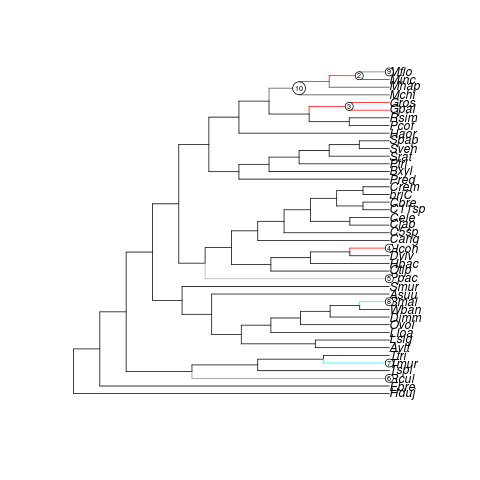

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Dviv
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Ebre


$n_steps
[1] 2

$lnls
              [,1]      [,2]
YR.Ngaro -91.43577 -100.4801

$n_regimes_seq
               [,1] [,2]
k                11   11
kprime           11    6
deltak            0    5
c                 0    9
kprime_conv       0    4
kprime_nonconv   11    2

$aics
       1        2 
297.5382 272.0037 

$shifts
  1   2  60  83  29  66  58  22  73  19  42 
"a" "b" "c" "d" "e" "d" "e" "a" "d" "j" "j" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
            11              6              5              9              4 
kprime_nonconv 
             2 

$alpha
YR.Ngaro 
4616.884 

$phylhalflife
    YR.Ngaro 
0.0001501331 

$sigma_squared
YR.Ngaro 
57881.05 

$theta
   YR.Ngaro
a  13.60000
b 200.50000
c 226.00000
d  54.66667
e  33.50000
j   1.10000



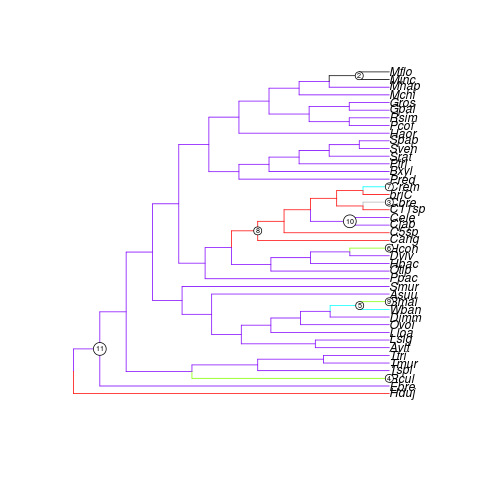

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Ant1 was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Ant1 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Ant1 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Ant1 was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Ant1 was not found in sample Asuu
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Ant1 was not found in sample Haor
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Ant1 was not found in sample Bmal
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: 

$n_steps
[1] 3

$lnls
                    [,1]      [,2]      [,3]
DNA.TcMar.Ant1 -115.4606 -118.0694 -119.1671

$n_regimes_seq
               [,1] [,2] [,3]
k                 7    7    7
kprime            7    5    4
deltak            0    2    3
c                 0    4    6
kprime_conv       0    2    3
kprime_nonconv    7    3    1

$aics
       1        2        3 
283.8442 279.1388 276.8860 

$shifts
  1  23  63  52  66  36  15 
"a" "b" "c" "b" "c" "f" "f" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
             7              4              3              6              3 
kprime_nonconv 
             1 

$alpha
DNA.TcMar.Ant1 
      655.7144 

$phylhalflife
DNA.TcMar.Ant1 
   0.001057087 

$sigma_squared
DNA.TcMar.Ant1 
      19611.59 

$theta
  DNA.TcMar.Ant1
a       7.437500
b      29.000000
c      48.000000
f       2.043478



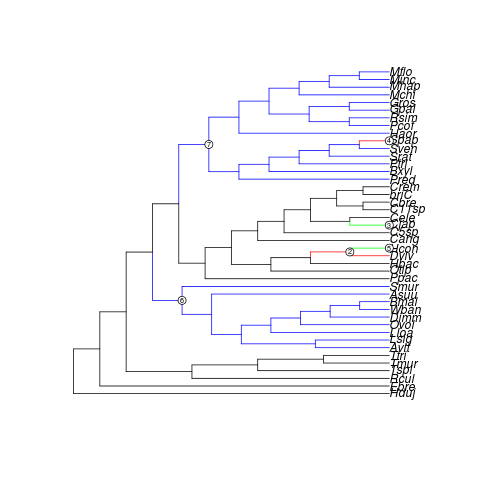

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample Hbak
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample Mflo
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample Dviv
/usr/loc

$n_steps
[1] 2

$lnls
             [,1]      [,2]
LINE.R2 -94.43848 -94.65146

$n_regimes_seq
               [,1] [,2]
k                 8    8
kprime            8    6
deltak            0    2
c                 0    3
kprime_conv       0    1
kprime_nonconv    8    5

$aics
      1       2 
253.377 242.226 

$shifts
  1  60  37  73  83  84  80  29 
"a" "b" "c" "d" "c" "c" "g" "h" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
             8              6              2              3              1 
kprime_nonconv 
             5 

$alpha
 LINE.R2 
8588.425 

$phylhalflife
     LINE.R2 
8.070713e-05 

$sigma_squared
 LINE.R2 
82099.92 

$theta
     LINE.R2
a  60.000000
b 225.000000
c   1.111111
d  71.000000
g  27.000000
h  11.000000



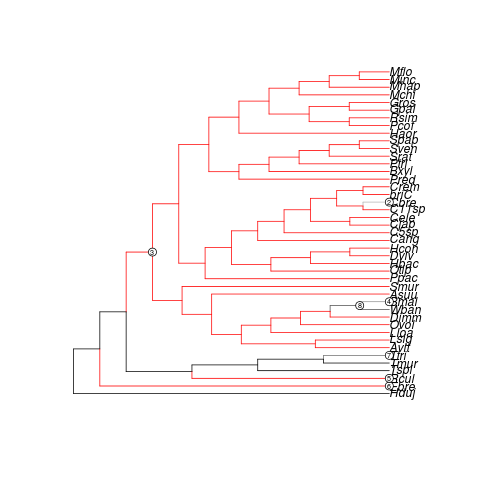

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-NeSL was not found in sample Hbak
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-NeSL was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-NeSL was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-NeSL was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-NeSL was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-NeSL was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-NeSL was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-Ne

$n_steps
[1] 2

$lnls
                  [,1]      [,2]
LINE.R2.NeSL -81.39758 -84.79553

$n_regimes_seq
               [,1] [,2]
k                10   10
kprime           10    7
deltak            0    3
c                 0    6
kprime_conv       0    3
kprime_nonconv   10    4

$aics
       1        2 
257.3952 240.6345 

$shifts
  1  57  18  82  59  61  83  69  64  46 
"a" "b" "c" "d" "e" "f" "g" "g" "f" "e" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
            10              7              3              6              3 
kprime_nonconv 
             4 

$alpha
LINE.R2.NeSL 
    9872.629 

$phylhalflife
LINE.R2.NeSL 
7.020897e-05 

$sigma_squared
LINE.R2.NeSL 
    59688.28 

$theta
  LINE.R2.NeSL
a      1.30303
b    134.00000
c     90.00000
d     72.00000
e      9.50000
f     23.00000
g     39.50000



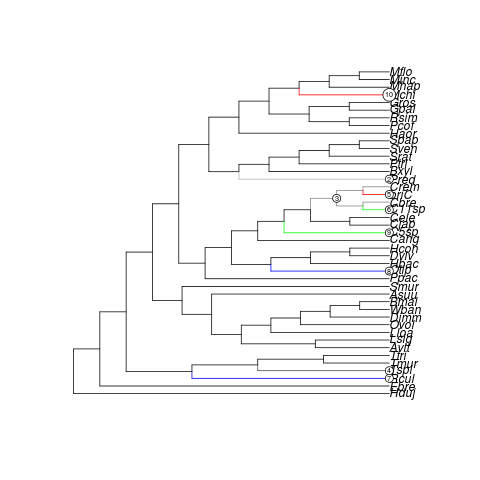

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/P_element was not found in sample Hbak
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/P_element was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/P_element was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/P_element was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/P_element was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/P_element was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/P_element was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA

$n_steps
[1] 3

$lnls
                   [,1]      [,2]      [,3]
DNA.P_element -18.82017 -19.05878 -20.08948

$n_regimes_seq
               [,1] [,2] [,3]
k                 9    9    9
kprime            9    6    5
deltak            0    3    4
c                 0    6    7
kprime_conv       0    3    3
kprime_nonconv    9    3    2

$aics
        1         2         3 
115.82216  96.59756  93.10204 

$shifts
  1  65  64  41   4  60  44  55  73 
"a" "b" "c" "d" "a" "a" "d" "h" "h" 

$n_regimes
             k         kprime         deltak              c    kprime_conv 
             9              5              4              7              3 
kprime_nonconv 
             2 

$alpha
DNA.P_element 
       915.39 

$phylhalflife
DNA.P_element 
 0.0007572152 

$sigma_squared
DNA.P_element 
     272.8973 

$theta
  DNA.P_element
a     3.5000000
b    10.0000000
c     5.0000000
d     0.1818182
h     2.0000000



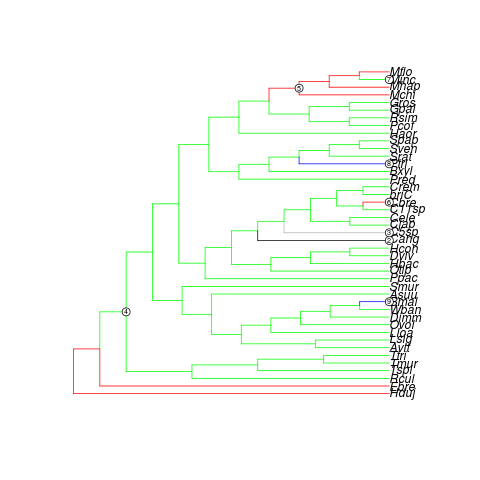

In [18]:
# Run surface
%R library(surface)
%R tree <- read.tree('model_testing/no_wtsi_input.tre.ultra')
%R tree <- nameNodes(tree)    

surface_results = {}

for e in TEs: # for each class or superfamily
    
    # Make a dataframe
    df = make_df_from_project(pj, 'keep', expected_codes, [e], sep=",", head=True)
    %Rpush df
    E = e.replace('/','.').replace('-','.')
    %Rpush E
    
    # Small R fixes to dataframe
    %R row.names(df) <- df[,'sample']
    %R keeps <- c(E)
    %R for (i in names(df)){df[[i]] <- as.numeric(df[[i]])}
    silent = %R df <- df[keeps]
    
    # Run surface
    %R s <- runSurface(tree, df, error_skip=TRUE)
    %R fsum <- surfaceSummary(s$bwd)
    %R print(fsum)
    %R kk<-length(s$bwd)
    %R surfaceTreePlot(tree, s$bwd[[kk]], labelshifts = T)
    %R results <- fsum
    %Rpull results
    
    # Put results in dict
    surface_results[e] = results

In [19]:
import cloud.serialization.cloudpickle as pickle
pickle_file_name = 'model_testing/no_wtsi_surface_loop_result_dfs.pkl'
output = open(pickle_file_name,'wb')
pickle.dump(surface_results, output)
output.close()

## 10.20 Translate R tree tips to species codes

In [20]:
rtips = {'1': 'Hduj',
            '2': 'Ebre',
            '3': 'Rcul',
            '4': 'Tspi',
            '5': 'Tmur',
            '6': 'Ttri',
            '7': 'Smur',
            '8': 'Asuu',
            '9': 'Avit',
            '10': 'Lsig',
            '11': 'Lloa',
            '12': 'Ovol',
            '13': 'Dimm',
            '14': 'Wban',
            '15': 'Bmal',
            '16': 'Ppac',
            '17': 'Otip',
            '18': 'Hbac',
            '19': 'Dviv',
            '20': 'Hbac',
            '21': 'Hcon',
            '22': 'Cang',
            '23': 'C5sp',
            '24': 'Cjap',
            '25': 'Cele',
            '26': 'C11sp',
            '27': 'Cbre',
            '28': 'briC',
            '29': 'Crem',
            '30': 'Pred',
            '31': 'Bxyl',
            '32': 'Ptri',
            '33': 'Srat',
            '34': 'Sven',
            '35': 'Spap',
            '36': 'Pcof',
            '37': 'Rsim',
            '38': 'Gpal',
            '39': 'Gros',
            '40': 'Mchi',
            '41': 'Mhap',
            '42': 'Minc',
            '43': 'Mflo'}

## 10.21 Trees with species codes as leaf names
`independent_contrasts/input.tre` is the phylobayes tree with the species codes as leaf names, instead of feature ids.  
`independent_contrasts/no_wtsi_input.tre` is a version of this tree that exclude species with unpublished genomes.

In [21]:
t = Tree('independent_contrasts/input.tre')

for n in ['Acan', 'Asim', 'Bpah', 'Btim', 'Ever', 'Sbat', 'Tcan']:
    (t&n).delete()
    
t.set_outgroup(t&'Hduj')
t.dist=0

t.write(outfile='independent_contrasts/no_wtsi_input.tre', format=5)



## 10.22 Plot a summary of the Surface analysis.
Median theta changes for each TE class

In [ ]:
import pandas as pd
from reprophylo import *

pj = unpickle_pj('independent_contrasts/18S_tree_reprophylo_project_with_TE_style_and_RNAi', git=False)
%R library(phytools)
%R library(surface)

# Collect the models to ru simulations later
models = {}

%R tree <- read.tree('model_testing/no_wtsi_input.tre.ultra')

for clas in ['DNA','LINE','LTR','SINE']:
    t = Tree('independent_contrasts/no_wtsi_input.tre')
    ts = TreeStyle()
    ts.scale = 500
    ts.show_leaf_name = False
    for n in t.traverse():
        ns = NodeStyle()
        ns['size'] = 0
        ns['fgcolor']='white'
        n.set_style(ns)
        
        # features to summarize thethas,
        # proportion of changes and 
        # median theta change
        n.add_feature('thetas',{})
        n.add_feature('propchange',{})
        n.add_feature('median_change',None)
        n.add_feature('count_thetas',0)
        
    for i in surface_results.keys():
        if clas in i:
            
            # Turn the R results df
            # to pandas results df
            pydf2 = surface_results[i]
            #print pydf2
            
            # Get params
            element = i
            alpha = pydf2[6][0]
            shifts = list(pydf2[4].items())
            sgsq = pydf2[8][0]
            
            # Ancestral theta
            firsttheta = pydf2[9][0]
            
            # Theth shfits and their nodes
            # on the R tree (numbered nodes)
            theta = []
            for j in range(len(list(pydf2[9]))):
                theta.append([shifts[j][0],shifts[j][1], pydf2[9][j]])
            
            # Place thetas on the python tree
            # (namesed leaves)
            for th in theta:
                nodenum = int(th[0])
                %Rpush nodenum
                %R decs <- getDescendants(tree, nodenum)
                %Rpull decs
                leaves = []
                for d in decs:
                    if str(d) in rtips:
                        leaves.append(rtips[str(d)])
                node = t.get_common_ancestor(leaves)
                node.thetas[element]=th[2]
                node.count_thetas += 1
            
            # Fill the gaps for nodes with no Theta:
            # Theta = the Theta of the parent
            for n in t.traverse('preorder'):
                if not n.is_root() and not element in n.thetas:
                    parent = n.up
                    found = False
                    if element in parent.thetas.keys():
                        n.thetas[element] = parent.thetas[element]
                        found = True
            # Calculate the Theta prop change in each node
            # for each element
            for n in t.traverse():          
                if n.is_root():
                    n.propchange[element] = 1
                elif n.up:
                    n.propchange[element] = int(n.thetas[element])/float(n.up.thetas[element])
            # Summarize all the OU models in the models dictionary
            models[element] = [alpha, sgsq, firsttheta]    
                
        
    
    for n in t.traverse():
        # Add leaf labels to the python tree
        if n.is_leaf():
            f_id = pj.fr('18S', filter=[['keep',n.name]])[0].id
            orgn = get_qualifiers_dictionary(pj,f_id)['source_organism']
            n.add_face(TextFace(orgn), 0,'branch-right')
            
        # Calculate the median Theta change and put
        # a bullet
        if not n.thetas == {}:
            n.median_change = np.median(n.propchange.values())
            
            color = 'black'
            if n.median_change > 1.1:
                color = 'DodgerBlue'
            elif n.median_change < 0.99:
                color = 'OrangeRed'
            n.add_face(CircleFace(n.median_change*2, color), 1, 'float')
            if n.count_thetas > 0 and not n.is_root():
                n.add_face(TextFace(str(n.count_thetas)), 0, 'float')
        
    t.render('model_testing/no_wtsi_surface_%s.png'%clas, h=500, tree_style=ts)
               

### Simulate evolutionary trajectories of the fitted OU models

DNA/TcMar-Tc1 - sigma: 18299.222, alpha: 1132.879, theta: 196


/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Package 'Sim.DiffProc' version 3.0 loaded: help(Sim.DiffProc) for summary information.

  res = super(Function, self).__call__(*new_args, **new_kwargs)


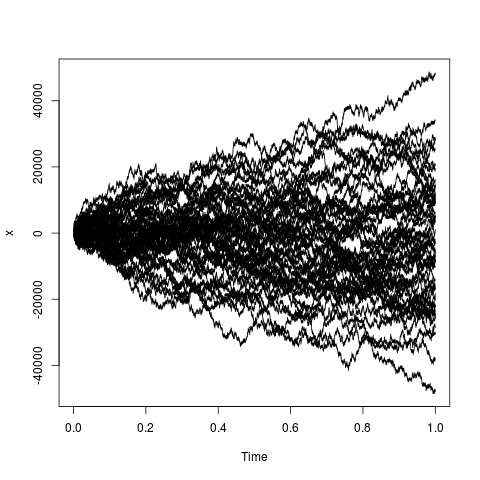

DNA/TcMar-Tc2 - sigma: 33661.338, alpha: 380336.436, theta: 18


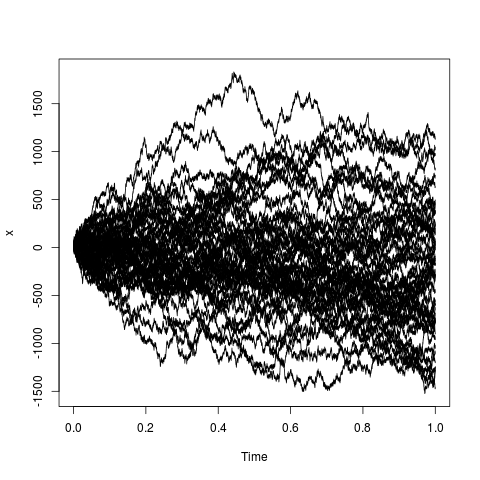

DNA/TcMar-Tc4 - sigma: 1592.400, alpha: 744221.770, theta: 141


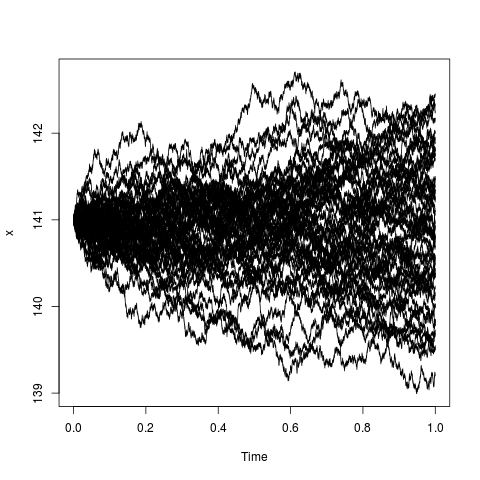

DNA/TcMar-Ant1 - sigma: 140.041, alpha: 655.714, theta: 7


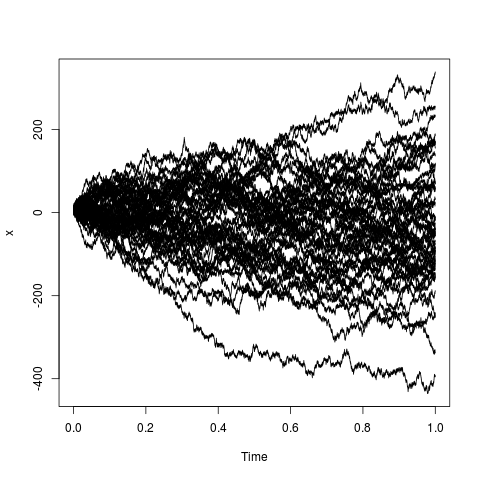

LTR/Pao - sigma: 403.237, alpha: 0.889, theta: 298


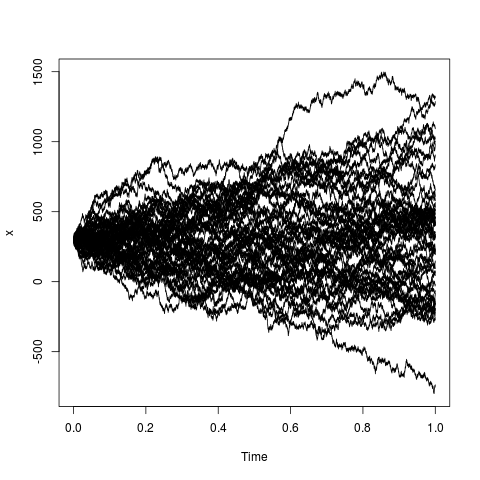

LINE/L1 - sigma: 573.917, alpha: 4984.142, theta: 3


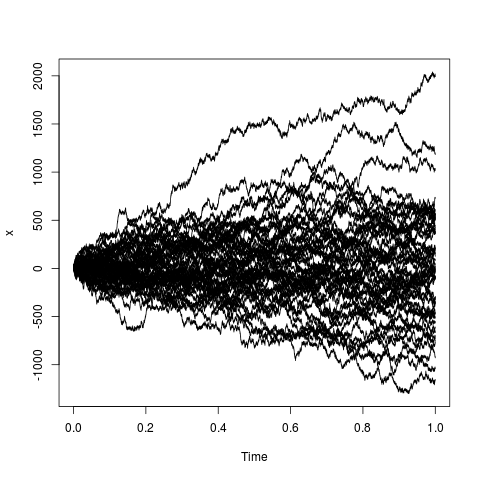

LINE/R1 - sigma: 2068.335, alpha: 111246.632, theta: 5


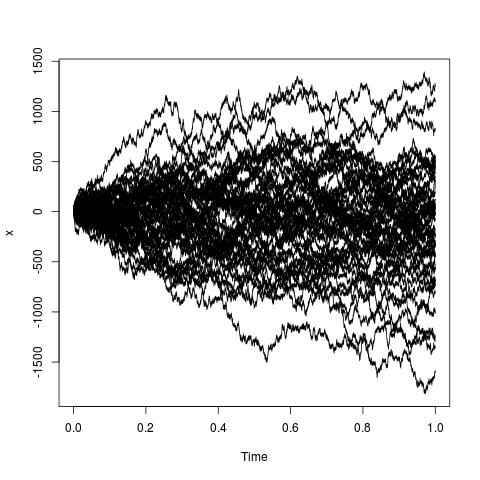

LINE/R2 - sigma: 286.531, alpha: 8588.425, theta: 60


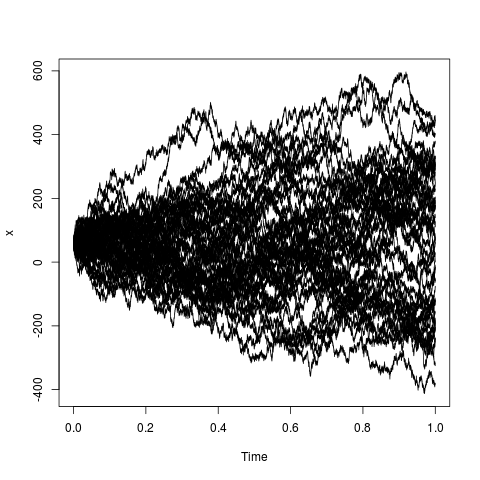

LINE/R2-NeSL - sigma: 244.312, alpha: 9872.629, theta: 1


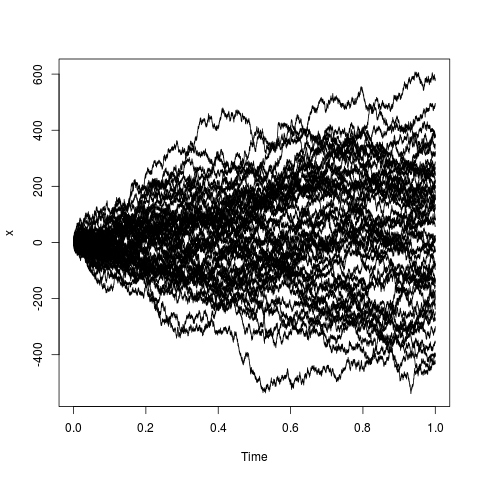

DNA/PiggyBac - sigma: 7502.697, alpha: 490453.042, theta: 4


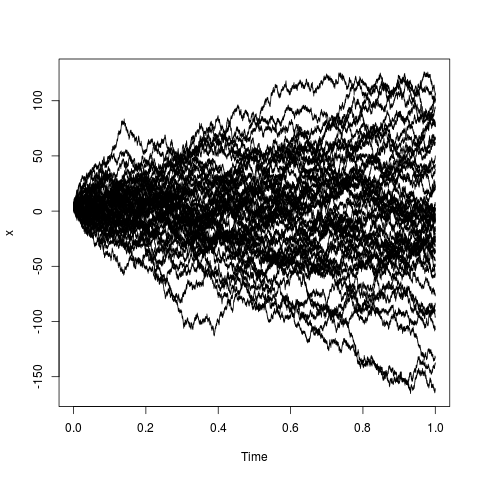

DNA/hAT - sigma: 7970.279, alpha: 492.398, theta: 141


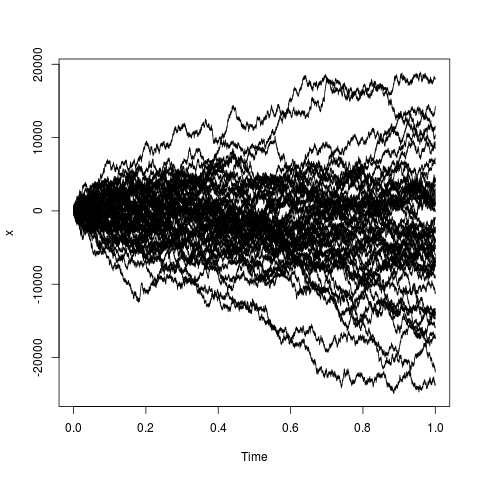

DNA/TcMar-Mariner - sigma: 21096.130, alpha: 9905.827, theta: 84


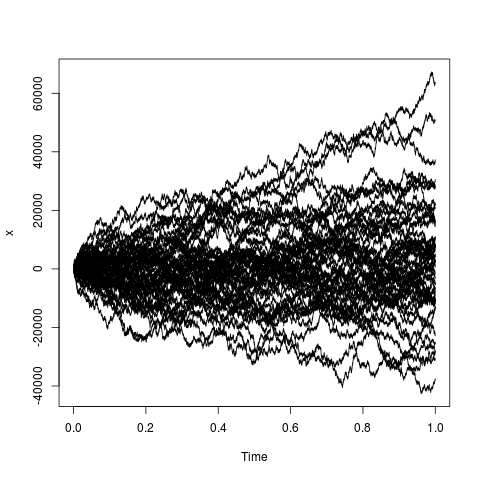

LINE/RTE-RTE - sigma: 0.000, alpha: 26674593.809, theta: 0


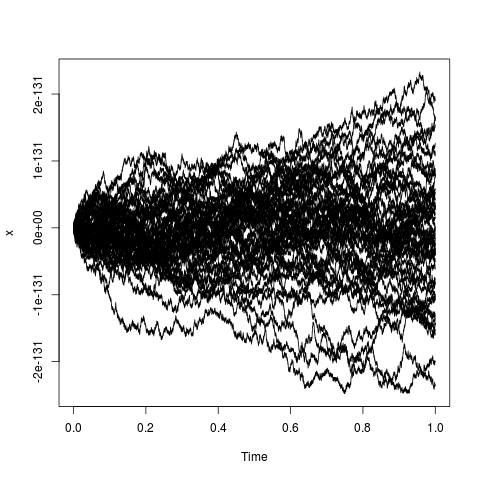

DNA/P_element - sigma: 16.520, alpha: 915.390, theta: 3


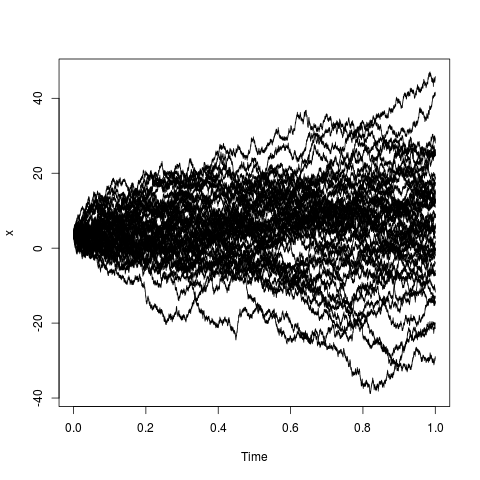

DNA/Helitron - sigma: 13406.917, alpha: 723.803, theta: 3303


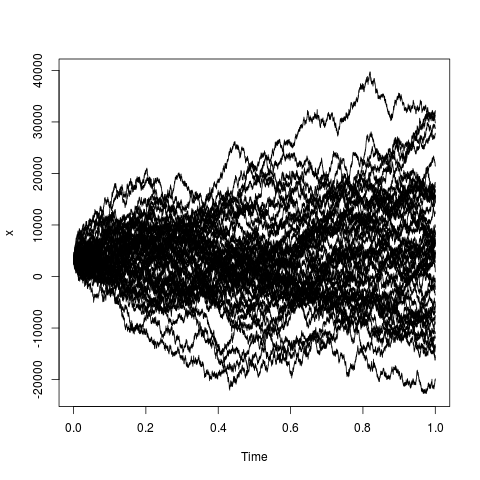

SINE/Alu - sigma: 159.255, alpha: 4060.136, theta: 1


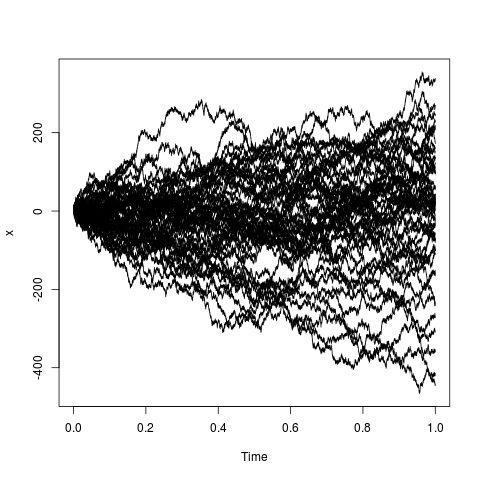

DNA/Merlin - sigma: 168.270, alpha: 10.958, theta: 18


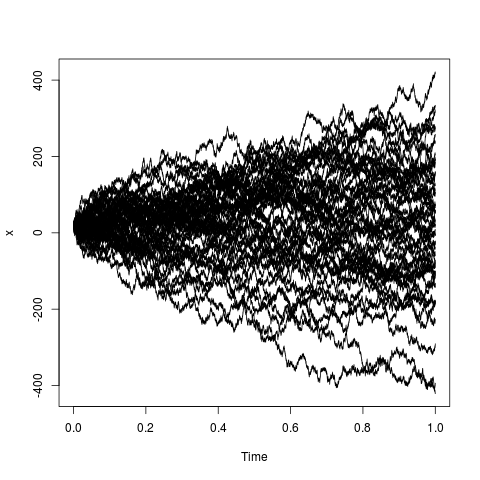

DNA/hAT-Ac - sigma: 1705.193, alpha: 354.430, theta: 34


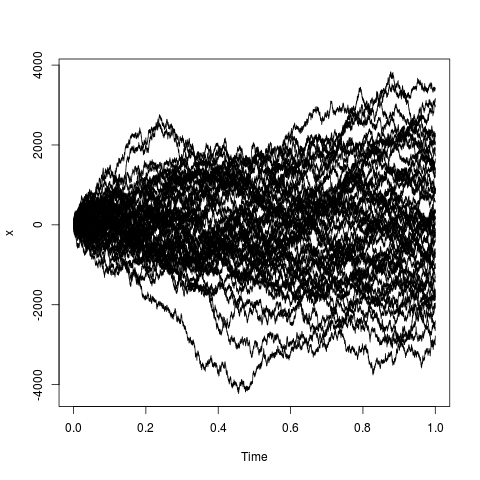

LINE/Penelope - sigma: 35.063, alpha: 148756.446, theta: 9031


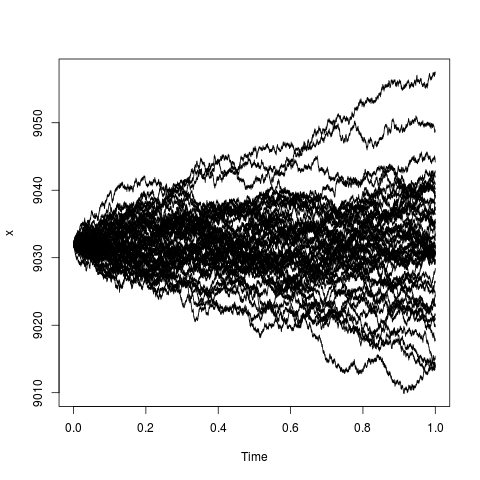

DNA/Ginger2 - sigma: 0.000, alpha: 346330.531, theta: 0


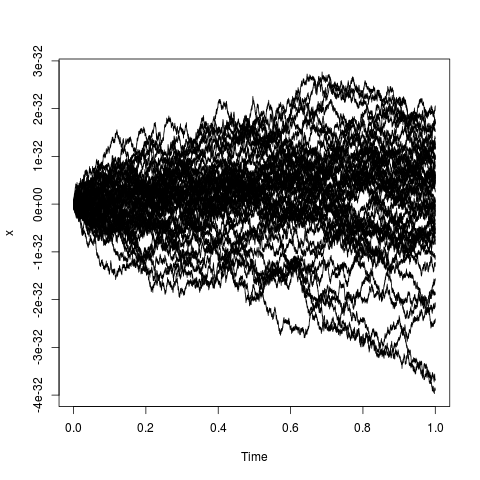

LINE/CR1 - sigma: 99.707, alpha: 10.771, theta: 205


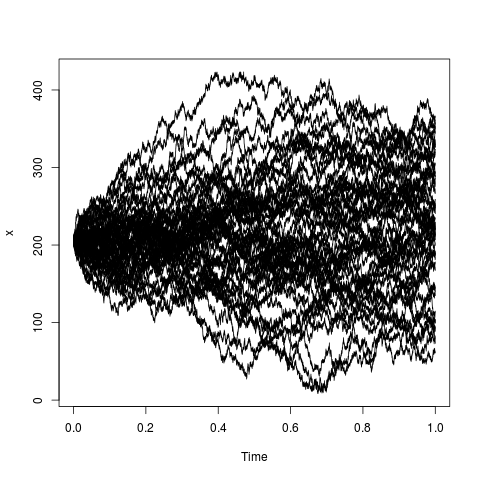

DNA/TcMar-Pogo - sigma: 0.000, alpha: 1695401.340, theta: 0


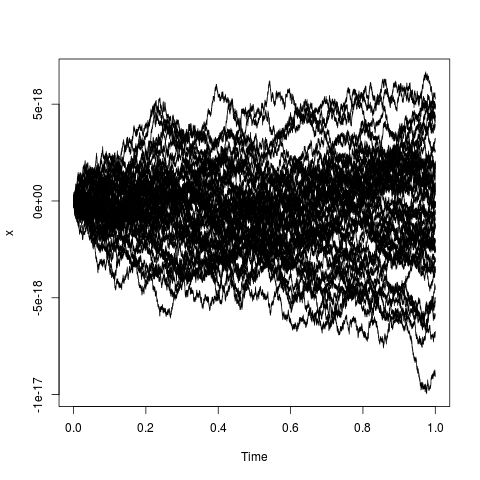

LTR/Copia - sigma: 3656.216, alpha: 3357.308, theta: 41


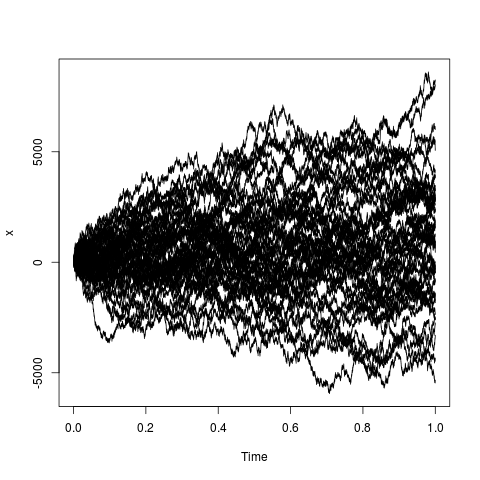

DNA/MuLE-MuDR - sigma: 9832.604, alpha: 2413.248, theta: 124


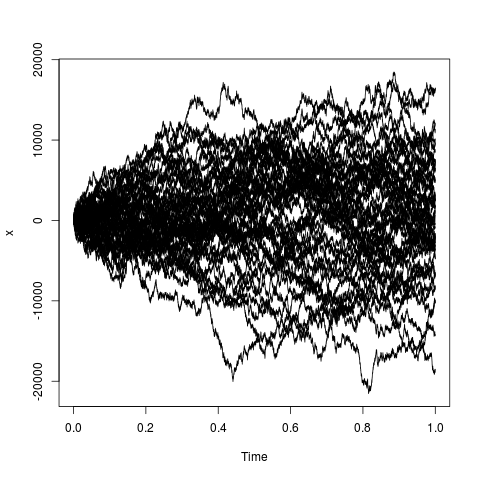

In [86]:
%R -w 30 -h 30 -u cm

import math

for element in models:
    sigma = math.sqrt(abs(models[element][1]))
    alpha = models[element][0]
    theta = models[element][2]
    %Rpush sigma
    %Rpush alpha
    %Rpush theta
    %R library(Sim.DiffProc)
    
    print "%s - sigma: %.3f, alpha: %.3f, theta: %i"%(element, sigma, alpha, theta)
    
    %R x <- HWV(N=100000, M=50, mu=alpha, theta=theta, sigma=sigma, x0=theta)
    %R plot(x, plot.type="single")

## 10.23 Functions to run Ancestral state reconstruction of TE loads, ANOVA on independent contrasts and corrolation of ancestral states

In [1]:
%load_ext rmagic

/usr/local/lib/python2.7/dist-packages/IPython/extensions/rmagic.py:693: UserWarning: The rmagic extension in IPython is deprecated in favour of rpy2.ipython. If available, that will be loaded instead.
http://rpy.sourceforge.net/
  warnings.warn("The rmagic extension in IPython is deprecated in favour of "


In [97]:
%%R

# Will check the overlap of samples
# between tree and df
test_nodes <- function(df, treefile){
    library(ape)
    library(geiger)
    require(phytools)
    row.names(df) <- df$sample
    tree <-read.tree(treefile)
    O.overlap <- name.check(tree, df)
    return(O.overlap)
}

# Will run ANOVA on independent contrasts
ANOVA <- function(df, treefile, groups, cont_var) {
                                                   
    library(ape)
    library(geiger)
    require(phytools)
    
    row.names(df) <- df$sample 
    
    tree <-read.tree(treefile)
    
    A <- df[,groups]
    B <- df[,cont_var]
    
    names(A) <- rownames(df)
    names(B) <- rownames(df)   
    
    return(phylANOVA(tree, A, B))
}

# Will compute correlation between ancestral states
# of two traits (GC content and TE loads)
CORR <- function(df, treefile, element) {
                                                   
    library(ape)
    library(geiger)
    require(phytools)
    library(pastecs)
    
    row.names(df) <- df$sample 
    
    tree <-read.tree(treefile)
    
    A <- df$AssemblyGC
    B <- df[,element]
    
    names(A) <- rownames(df)
    names(B) <- rownames(df)   
    
    return(ratebystate(tree, A, B))
}

# Will compute correlation between ancestral states
# of two traits (assembly_length and TE loads)
CORR1 <- function(df, treefile, element) {
                                                   
    library(ape)
    library(geiger)
    require(phytools)
    library(pastecs)
    
    row.names(df) <- df$sample 
    
    tree <-read.tree(treefile)
    
    A <- df$assembly_length
    B <- df[,element]
    
    names(A) <- rownames(df)
    names(B) <- rownames(df)   
    
    return(ratebystate(tree, A, B))
}

# Detect evolutionary rate shifts of the trait (TE) on the tree
RATESHIFT <- function(df, treefile, element, nrates=1, niter=10) {
                                                   
    library(ape)
    library(geiger)
    require(phytools)
    library(pastecs)
    
    row.names(df) <- df$sample 
    
    tree <-read.tree(treefile)
    
    B <- df[,element]
    
    names(B) <- rownames(df)   
    
    return(rateshift(tree, B, nrates=nrates, niter=niter))
}

# Reconstruct ancestral states of the trait
FASTANC <- function(df, treefile, element, vars=FALSE, CI=FALSE) {
                                                   
    library(ape)
    library(geiger)
    require(phytools)
    library(pastecs)
    
    row.names(df) <- df$sample 
    
    tree <-read.tree(treefile)
    
    B <- df[,element]
    
    names(B) <- rownames(df)   
    
    return(fastAnc(tree, B, vars=vars, CI=CI))
}

# Write ancestral states to a tree
WRITEANCESTORS <- function(treefile, outfile, Anc, digits=0) {
                                                   
    library(ape)
    library(geiger)
    require(phytools)
    library(pastecs)  
    
    tree <-read.tree(treefile)
    
    return(writeAncestors(tree, Anc=Anc, file=outfile, digits=digits, format="phylip"))
}



## 10.24 ANOVA of TE independent contrasts

In [38]:
import pandas.rpy.common as com

pj = unpickle_pj('independent_contrasts/18S_tree_reprophylo_project_with_TE_style_and_RNAi', git=False)

# Get the relevant genome codes
expected_codes =Tree('independent_contrasts/no_wtsi_input.tre').get_leaf_names()
        

# Make a list of TE class and superfamily names
# which occur in at least 15 species

import cloud.serialization.cloudpickle as pickle
pickle_file_name = 'fit_of_TEs_to_tree/no_wtsi_result_dfs.pkl'
pickle_handle = open(pickle_file_name, 'rb')
result_dfs = pickle.pickle.load(pickle_handle)

TEs = sorted([key for key in result_dfs.keys() if
              not 'Unclassified' in key and
              not '?' in key and
              len([r for r in pj.records if any([key in f.qualifiers.keys() for f in r.features])]) > 14 ],
             
             key=lambda n: sum([int(r.features[1].qualifiers[n][0]) for r in pj.records 
                                          if n in r.features[1].qualifiers.keys()]),
             reverse=True
             )        

print 'Total element groups tested: %i'%len(TEs)

# Run the ANOVA
Anova_pvalues = {}
ind = 1
for e in TEs:
    print '%s: %i of %i'%(e, ind, len(TEs))
    ind += 1
    Anova_pvalues[e] = {}
    # feature qualifiers to test:
    for param in ['M2','M3','M4','P2','P3','RNAi','piwi','rrf1','rrf3']:
        
        # Make a pandas dataframe for param and TE
        df = make_df_from_project(pj, 'keep', expected_codes, [param, e], sep=",", head=True)
        %Rpush df
        E = e.replace('/','.').replace('-','.')
        %Rpush E
        %Rpush param
        
        # Test param
        %R A <- ANOVA(df, 'independent_contrasts/no_wtsi_input.tre', param, E)
        %Rpull A
        #print A
        # Put pvalue in a dictionary
        pvalue = str(com.convert_robj(A)['Pf'][0])
        #print pvalue
        Anova_pvalues[e][param]=float(pvalue.split()[0])

Total element groups tested: 51
DNA: 1 of 51
LINE: 2 of 51
LTR: 3 of 51
DNA/TcMar-Tc1: 4 of 51
DNA/TcMar-Mariner: 5 of 51
LTR/Gypsy: 6 of 51
LINE/Penelope: 7 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc1 was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc1 was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc1 was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc1 was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc1 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc1 was not found in sample Haor
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc1 was not found in sample Pcof
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LIN


LINE/RTE-RTE: 8 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Penelope was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Penelope was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Penelope was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Penelope was not found in sample Dimm
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Penelope was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Penelope was not found in sample Bmal
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Penelope was not found in sample Otip
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LIN


DNA/Helitron: 9 of 51
DNA/hAT-Ac: 10 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-RTE was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-RTE was not found in sample Rcul
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-RTE was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-RTE was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-RTE was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-RTE was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-RTE was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-R


DNA/hAT: 11 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT-Ac was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT-Ac was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT-Ac was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT-Ac was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT-Ac was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT-Ac was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT-Ac was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT was not found in


LINE/RTE-BovB: 12 of 51
DNA/TcMar-Tc2: 13 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-BovB was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-BovB was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-BovB was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-BovB was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-BovB was not found in sample Dimm
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-BovB was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-BovB was not found in sample Otip
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LIN


LINE/CR1: 14 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc2 was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc2 was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc2 was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc2 was not found in sample Bmal
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc2 was not found in sample Asuu
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc2 was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc2 was not found in sample Ppac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA


DNA/EnSpm: 15 of 51
DNA/MuLE-MuDR: 16 of 51
DNA/TcMar-Tc4: 17 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Dimm
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Otip
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Bxyl
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Ptri



LTR/Pao: 18 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc4 was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc4 was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc4 was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc4 was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc4 was not found in sample Dimm
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc4 was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc4 was not found in sample Bmal
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA


DNA/PiggyBac: 19 of 51
LTR/Copia: 20 of 51
DNA/Maverick: 21 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyBac was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyBac was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyBac was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyBac was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyBac was not found in sample Dimm
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyBac was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyBac was not found in sample Asuu
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyB


LTR/Roo: 22 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Maverick was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Maverick was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Maverick was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Maverick was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Maverick was not found in sample Pcof
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Maverick was not found in sample Rsim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/Roo was not found in sample Srat



SINE: 23 of 51
DNA/Merlin: 24 of 51
DNA/Sola: 25 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found in sample Hduj
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found in sample Dimm
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found


LINE/R1: 26 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Sola was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Sola was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Sola was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Sola was not found in sample Otip
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Sola was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Sola was not found in sample Dviv
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Sola was not found in sample Pred
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Sola was not found in sample Ptri



DNA/TcMar-Pogo: 27 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R1 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R1 was not found in sample Pcof
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Pogo was not found in sample Hduj



DNA/Ginger2: 28 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Pogo was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Pogo was not found in sample Rcul
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Pogo was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Pogo was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Pogo was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Pogo was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Pogo was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: 


LINE/L2: 29 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was not found in sample Rcul
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was n


SINE/Alu: 30 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L2 was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L2 was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L2 was not found in sample Otip
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L2 was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L2 was not found in sample Pred
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L2 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L2 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L2 was not found in sample Pcof
/usr/loc


LINE/Jockey: 31 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Rcul
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Smur



LINE/L1: 32 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Jockey was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Jockey was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Jockey was not found in sample Pcof
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Ebre



DNA/Ginger: 33 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Dviv
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Cjap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Cele
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Spap
/usr/loc


DNA/PIF-Harbinger: 34 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger was not found in sample Ppac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger was not found in sample Cang
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger was not found in sample C5sp
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger was not found in sample Cjap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger was not found in sample Cele
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger was not found


YR/DIRS: 35 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PIF-Harbinger was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PIF-Harbinger was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PIF-Harbinger was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PIF-Harbinger was not found in sample Dimm
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PIF-Harbinger was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PIF-Harbinger was not found in sample Bmal
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PIF-Harbinger was not found in sample Asuu
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__


LTR/ERVK: 36 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/DIRS was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/DIRS was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/DIRS was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/DIRS was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/DIRS was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/DIRS was not found in sample Otip
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/DIRS was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/DIRS was not found in sample Dviv
/usr/loc


YR/Ngaro: 37 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERVK was not found in sample Ppac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERVK was not found in sample Otip
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERVK was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERVK was not found in sample C5sp
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERVK was not found in sample Cjap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERVK was not found in sample Cele
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERVK was not found in sample Pred
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERVK was not found in sample Bxyl



LTR/ERV1: 38 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Dimm



DNA/ISC1316: 39 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERV1 was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERV1 was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERV1 was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERV1 was not found in sample Hcon
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERV1 was not found in sample Pred
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERV1 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERV1 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERV1 was not found in sample Sven



SINE/ID: 40 of 51
DNA/TcMar-Ant1: 41 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/ID was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/ID was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Ant1 was not found in sample Tspi



LINE/R2: 42 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Ant1 was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Ant1 was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Ant1 was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Ant1 was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Ant1 was not found in sample Bmal
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Ant1 was not found in sample Asuu
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Ant1 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: 


LINE/R2-NeSL: 43 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample Otip
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample Dviv
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample Hcon
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample Cang
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample Cjap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample briC
/usr/loc


SINE/5S: 44 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-NeSL was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-NeSL was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-NeSL was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-NeSL was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-NeSL was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-NeSL was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-NeSL was not found in sample Ppac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-Ne


YR/Crypton: 45 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/5S was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/5S was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/5S was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/5S was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/5S was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/5S was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/5S was not found in sample Dimm
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/5S was not found in sample Wban
/usr/loc


DNA/Novosib: 46 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Crypton was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Crypton was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Crypton was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Crypton was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Crypton was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Crypton was not found in sample Bmal
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Crypton was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Crypton was not found


DNA/Kolobok-Hydra: 47 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Novosib was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Novosib was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Novosib was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Novosib was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Novosib was not found in sample Ppac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Novosib was not found in sample Otip
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Novosib was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Novosib was n


YR/Viper: 48 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Kolobok-Hydra was not found in sample Rcul
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Kolobok-Hydra was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Kolobok-Hydra was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Kolobok-Hydra was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Kolobok-Hydra was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Kolobok-Hydra was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Kolobok-Hydra was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__


DNA/ISb: 49 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Viper was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Viper was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Viper was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Viper was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Viper was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Viper was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Viper was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Viper was not found in sample Smur



DNA/P_element: 50 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISb was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISb was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISb was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISb was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISb was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISb was not found in sample Dimm
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISb was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISb was not found in sample Bmal
/usr/loc


DNA/ISa: 51 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/P_element was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/P_element was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/P_element was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/P_element was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/P_element was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/P_element was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/P_element was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISa was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISa was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISa was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISa was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISa was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISa was not found in sample Dviv
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISa was not found in sample Hcon
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISa was not found in sample C5sp
/usr/loc

In [39]:
Anova_pvalues['DNA/hAT']

{'M2': 0.644,
 'M3': 0.811,
 'M4': 0.876,
 'P2': 0.262,
 'P3': 0.304,
 'RNAi': 0.81,
 'piwi': 0.447,
 'rrf1': 0.722,
 'rrf3': 0.99}

In [40]:
import cloud.serialization.cloudpickle as pickle
pickle_file_name = 'independent_contrasts/no_wtsi_Anova_pvalues.pkl'
output = open(pickle_file_name,'wb')
pickle.dump(Anova_pvalues, output)
output.close()

## 10.25 Corrolation of GC content or Assembly length with TE load ancestral states

In [ ]:
# Make class and superfamily name list, which occur
# in at least 15 species
import cloud.serialization.cloudpickle as pickle
pickle_file_name = 'fit_of_TEs_to_tree/no_wtsi_result_dfs.pkl'
pickle_handle = open(pickle_file_name, 'rb')
result_dfs = pickle.pickle.load(pickle_handle)

TEs = sorted([key for key in result_dfs.keys() if
              not 'Unclassified' in key and
              not '?' in key and
              len([r for r in pj.records if any([key in f.qualifiers.keys() for f in r.features])]) > 14 ],
             
             key=lambda n: sum([int(r.features[1].qualifiers[n][0]) for r in pj.records 
                                          if n in r.features[1].qualifiers.keys()]),
             reverse=True
             )        

print 'Total element groups tested: %i'%len(TEs)


Corr_pvalues = {}
ind = 1
for e in TEs:
    print '%s: %i of %i'%(e, ind, len(TEs))
    ind += 1
    Corr_pvalues[e] = {}
    
    # Make a df with the counts and GC content
    df = make_df_from_project(pj, 'keep', expected_codes, ['AssemblyGC', e], sep=",", head=True)
    %Rpush df
    E = e.replace('/','.').replace('-','.')
    %Rpush E
    
    # Test corrolation
    %R O <- CORR(df, "independent_contrasts/no_wtsi_input.tre", E)
    %Rpull O
    
    #print O
    
    # Put the pvalue in the dictionary
    corr_r = com.convert_robj(O)['r'][0]
    pvalue = com.convert_robj(O)['P'][0]
    Corr_pvalues[e]=[float(corr_r), float(pvalue)]

In [42]:
Corr_pvalues['DNA']

[0.09717757012610292, 0.44]

In [43]:
import cloud.serialization.cloudpickle as pickle
pickle_file_name = 'independent_contrasts/no_wtsi_Corr_pvalues.pkl'
output = open(pickle_file_name,'wb')
pickle.dump(Corr_pvalues, output)
output.close()

In [104]:
import pandas.rpy.common as com

pj = unpickle_pj('independent_contrasts/18S_tree_reprophylo_project_with_TE_style_and_RNAi', git=False)

# Get the relevant genome codes
expected_codes =Tree('independent_contrasts/no_wtsi_input.tre').get_leaf_names()


# Make class and superfamily name list, which occur
# in at least 15 species


import cloud.serialization.cloudpickle as pickle
pickle_file_name = 'fit_of_TEs_to_tree/no_wtsi_result_dfs.pkl'
pickle_handle = open(pickle_file_name, 'rb')
result_dfs = pickle.pickle.load(pickle_handle)
TEs = sorted([key for key in result_dfs.keys() if
              not 'Unclassified' in key and
              not '?' in key and
              len([r for r in pj.records if any([key in f.qualifiers.keys() for f in r.features])]) > 14 ],
             
             key=lambda n: sum([int(r.features[1].qualifiers[n][0]) for r in pj.records 
                                          if n in r.features[1].qualifiers.keys()]),
             reverse=True
             )        

print 'Total element groups tested: %i'%len(TEs)
Corr_pvalues_alen = {}
ind = 1
for e in TEs:
    print '%s: %i of %i'%(e, ind, len(TEs))
    ind += 1
    Corr_pvalues_alen[e] = {}
    
    # Make a df with the counts and GC content
    df = make_df_from_project(pj, 'keep', expected_codes, ['assembly_length', e], sep=",", head=True)
    %Rpush df
    E = e.replace('/','.').replace('-','.')
    %Rpush E
    
    # Test corrolation
    %R O <- CORR1(df, "independent_contrasts/no_wtsi_input.tre", E)
    %Rpull O
    
    # print O
    
    # Put the pvalue in the dictionary
    corr_r = com.convert_robj(O)['r'][0]
    pvalue = com.convert_robj(O)['P'][0]
    Corr_pvalues_alen[e]=[float(corr_r), float(pvalue)]

Total element groups tested: 51
DNA: 1 of 51
LINE: 2 of 51
LTR: 3 of 51
DNA/TcMar-Tc1: 4 of 51
DNA/TcMar-Mariner: 5 of 51
LTR/Gypsy: 6 of 51
LINE/Penelope: 7 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc1 was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc1 was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc1 was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc1 was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc1 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc1 was not found in sample Haor
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc1 was not found in sample Pcof
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LIN


LINE/RTE-RTE: 8 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Penelope was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Penelope was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Penelope was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Penelope was not found in sample Dimm
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Penelope was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Penelope was not found in sample Bmal
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Penelope was not found in sample Otip
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LIN


DNA/Helitron: 9 of 51
DNA/hAT-Ac: 10 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-RTE was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-RTE was not found in sample Rcul
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-RTE was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-RTE was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-RTE was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-RTE was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-RTE was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-R


DNA/hAT: 11 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT-Ac was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT-Ac was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT-Ac was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT-Ac was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT-Ac was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT-Ac was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT-Ac was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/hAT was not found in


LINE/RTE-BovB: 12 of 51
DNA/TcMar-Tc2: 13 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-BovB was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-BovB was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-BovB was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-BovB was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-BovB was not found in sample Dimm
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-BovB was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/RTE-BovB was not found in sample Otip
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LIN


LINE/CR1: 14 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc2 was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc2 was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc2 was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc2 was not found in sample Bmal
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc2 was not found in sample Asuu
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc2 was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc2 was not found in sample Ppac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA


DNA/EnSpm: 15 of 51
DNA/MuLE-MuDR: 16 of 51
DNA/TcMar-Tc4: 17 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Dimm
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Otip
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Bxyl
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/CR1 was not found in sample Ptri



LTR/Pao: 18 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc4 was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc4 was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc4 was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc4 was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc4 was not found in sample Dimm
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc4 was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Tc4 was not found in sample Bmal
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA


DNA/PiggyBac: 19 of 51
LTR/Copia: 20 of 51
DNA/Maverick: 21 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyBac was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyBac was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyBac was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyBac was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyBac was not found in sample Dimm
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyBac was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyBac was not found in sample Asuu
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PiggyB


LTR/Roo: 22 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Maverick was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Maverick was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Maverick was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Maverick was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Maverick was not found in sample Pcof
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Maverick was not found in sample Rsim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/Roo was not found in sample Srat



SINE: 23 of 51
DNA/Merlin: 24 of 51
DNA/Sola: 25 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found in sample Hduj
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found in sample Dimm
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Merlin was not found


LINE/R1: 26 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Sola was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Sola was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Sola was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Sola was not found in sample Otip
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Sola was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Sola was not found in sample Dviv
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Sola was not found in sample Pred
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Sola was not found in sample Ptri



DNA/TcMar-Pogo: 27 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R1 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R1 was not found in sample Pcof
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Pogo was not found in sample Hduj



DNA/Ginger2: 28 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Pogo was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Pogo was not found in sample Rcul
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Pogo was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Pogo was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Pogo was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Pogo was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Pogo was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: 


LINE/L2: 29 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was not found in sample Rcul
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger2 was n


SINE/Alu: 30 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L2 was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L2 was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L2 was not found in sample Otip
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L2 was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L2 was not found in sample Pred
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L2 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L2 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L2 was not found in sample Pcof
/usr/loc


LINE/Jockey: 31 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Rcul
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/Alu was not found in sample Smur



LINE/L1: 32 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Jockey was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Jockey was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/Jockey was not found in sample Pcof
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Ebre



DNA/Ginger: 33 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Dviv
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Cjap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Cele
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/L1 was not found in sample Spap
/usr/loc


DNA/PIF-Harbinger: 34 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger was not found in sample Ppac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger was not found in sample Cang
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger was not found in sample C5sp
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger was not found in sample Cjap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger was not found in sample Cele
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Ginger was not found


YR/DIRS: 35 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PIF-Harbinger was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PIF-Harbinger was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PIF-Harbinger was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PIF-Harbinger was not found in sample Dimm
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PIF-Harbinger was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PIF-Harbinger was not found in sample Bmal
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/PIF-Harbinger was not found in sample Asuu
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__


LTR/ERVK: 36 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/DIRS was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/DIRS was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/DIRS was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/DIRS was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/DIRS was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/DIRS was not found in sample Otip
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/DIRS was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/DIRS was not found in sample Dviv
/usr/loc


YR/Ngaro: 37 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERVK was not found in sample Ppac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERVK was not found in sample Otip
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERVK was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERVK was not found in sample C5sp
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERVK was not found in sample Cjap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERVK was not found in sample Cele
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERVK was not found in sample Pred
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERVK was not found in sample Bxyl



LTR/ERV1: 38 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Ngaro was not found in sample Dimm



DNA/ISC1316: 39 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERV1 was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERV1 was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERV1 was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERV1 was not found in sample Hcon
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERV1 was not found in sample Pred
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERV1 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERV1 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LTR/ERV1 was not found in sample Sven



SINE/ID: 40 of 51
DNA/TcMar-Ant1: 41 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/ID was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/ID was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Ant1 was not found in sample Tspi



LINE/R2: 42 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Ant1 was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Ant1 was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Ant1 was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Ant1 was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Ant1 was not found in sample Bmal
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Ant1 was not found in sample Asuu
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/TcMar-Ant1 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: 


LINE/R2-NeSL: 43 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample Otip
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample Dviv
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample Hcon
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample Cang
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample Cjap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2 was not found in sample briC
/usr/loc


SINE/5S: 44 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-NeSL was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-NeSL was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-NeSL was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-NeSL was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-NeSL was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-NeSL was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-NeSL was not found in sample Ppac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key LINE/R2-Ne


YR/Crypton: 45 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/5S was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/5S was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/5S was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/5S was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/5S was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/5S was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/5S was not found in sample Dimm
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key SINE/5S was not found in sample Wban
/usr/loc


DNA/Novosib: 46 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Crypton was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Crypton was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Crypton was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Crypton was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Crypton was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Crypton was not found in sample Bmal
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Crypton was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Crypton was not found


DNA/Kolobok-Hydra: 47 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Novosib was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Novosib was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Novosib was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Novosib was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Novosib was not found in sample Ppac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Novosib was not found in sample Otip
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Novosib was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Novosib was n


YR/Viper: 48 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Kolobok-Hydra was not found in sample Rcul
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Kolobok-Hydra was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Kolobok-Hydra was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Kolobok-Hydra was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Kolobok-Hydra was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Kolobok-Hydra was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/Kolobok-Hydra was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__


DNA/ISb: 49 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Viper was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Viper was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Viper was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Viper was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Viper was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Viper was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Viper was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key YR/Viper was not found in sample Smur



DNA/P_element: 50 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISb was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISb was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISb was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISb was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISb was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISb was not found in sample Dimm
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISb was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISb was not found in sample Bmal
/usr/loc


DNA/ISa: 51 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/P_element was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/P_element was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/P_element was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/P_element was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/P_element was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/P_element was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/P_element was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISa was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISa was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISa was not found in sample Lloa
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISa was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISa was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISa was not found in sample Dviv
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISa was not found in sample Hcon
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:39: UserWarning: key DNA/ISa was not found in sample C5sp
/usr/loc

### Significant results

In [44]:
# Correlation between GC content and TE counts

for e in Corr_pvalues:
    if Corr_pvalues[e][1] < 0.06:
        print e, Corr_pvalues[e]

LINE/L1 [-0.28517975551914987, 0.05]
LINE [0.3086725395828605, 0.05]
LINE/Penelope [0.37352846876823415, 0.02]
DNA/Ginger2 [-0.3308541796612552, 0.03]


In [102]:
# Correlation between assembly length and TE counts

for e in Corr_pvalues_alen:
    if Corr_pvalues_alen[e][1] < 0.06:
        print e, Corr_pvalues_alen[e]

LINE [0.4124039890554429, 0.02]
SINE/ID [0.45985143122687666, 0.02]
DNA/TcMar-Mariner [0.4042072692433278, 0.02]
LINE/RTE-RTE [0.46353337849320114, 0.01]
SINE/5S [0.4618054143578758, 0.01]


In [65]:
# Anova results

sig_count = 0
for e in Anova_pvalues:
    for param in Anova_pvalues[e]:
        if Anova_pvalues[e][param] < 0.06:
            print e, param, Anova_pvalues[e][param]
            sig_count += 1

DNA/ISC1316 M3 0.013
DNA/ISC1316 M2 0.005
YR/Ngaro M3 0.005
YR/Ngaro M4 0.045


## 10.26 TE load ancestral state recontruction
### DNA families

In [ ]:
import cloud.serialization.cloudpickle as pickle
pickle_file_name = 'fit_of_TEs_to_tree/no_wtsi_result_dfs.pkl'
pickle_handle = open(pickle_file_name, 'rb')
result_dfs = pickle.pickle.load(pickle_handle)
from reprophylo import *

pj = unpickle_pj('independent_contrasts/18S_tree_reprophylo_project_with_TE_style_and_RNAi', git=False)


TEs = sorted([key for key in result_dfs.keys() if
              not 'Unclassified' in key and
              not '?' in key and
              len([r for r in pj.records if any([key in f.qualifiers.keys() for f in r.features])]) > 14 ],
             
             key=lambda n: sum([int(r.features[1].qualifiers[n][0]) for r in pj.records 
                                          if n in r.features[1].qualifiers.keys()]),
             reverse=True
             ) 


# Get the relevant genome codes
expected_codes =Tree('independent_contrasts/no_wtsi_input.tre').get_leaf_names()
        
# Make a tree object
DNA_tree=Tree('independent_contrasts/no_wtsi_input.tre')

# For each superfamily:
for e in [k for k in TEs if 'DNA' in k and not k == 'DNA' and not 'nclassified' in k and not '?' in k]:
    
    # Make a dataframe with the superfamily counts
    df = make_df_from_project(pj, 'keep', expected_codes, [e], sep=",", head=True)
    %Rpush df
    E = e.replace('/','.').replace('-','.')
    %Rpush E
    
    # Compute ancestral states for this fuperfamily
    %R Anc <- FASTANC(df, 'independent_contrasts/no_wtsi_input.tre', E)
    %R WRITEANCESTORS('independent_contrasts/no_wtsi_input.tre', 'temp', Anc, digits=0)
    
    # Make a tree object out of the anotated tree
    anctrestr = open('temp','r').read().replace('&ancstate={','&&NHX:ancstate=').replace('}','')
    t = Tree(anctrestr)
    
    # Add leaf counts
    for l in t:
        from itertools import chain
        for f in chain(*[r.features for r in pj.records]):
            quals = f.qualifiers
            if 'keep' in quals and quals['keep'][0]==l.name:
                if e in quals:
                    l.add_feature('ancstate',quals[e][0])
                else:
                    l.add_feature('ancstate',0)
                    
    # make sure all leaves have ancstate
    # this will put 0 if no attr ancstate
    for n in t.traverse():
        setattr(n, 'ancstate', getattr(n, 'ancstate',0))
    
    # calculate proportion delta
    for n in t.traverse():
        if not n.is_root():
            count = n.ancstate
            parent_count = n.up.ancstate
            prop=None
            if float(parent_count) == 0:
                prop = 1
            elif float(parent_count) < 0.1 and count > 0.99:
                prop = 1.5
            elif float(parent_count) < 0.1 and count <= 0.99:
                prop = 1
            else:
            #print parent_count    
                prop = int(count)/float(parent_count)
            n.add_feature('ancstateprop',prop)
            leaf_names = n.get_leaf_names()
            master_node = None
            if n.is_leaf():
                master_node = DNA_tree&n.name
            else:
                master_node = DNA_tree.get_common_ancestor(leaf_names)
            try:
                master_node.ancstateprop.append(prop)
            except:
                master_node.add_feature('ancstateprop', [prop])
    t.write(outfile='independent_contrasts/anc/no_wtsi_%s.tre'%E, format=5, features=[])
DNA_tree.write(outfile='independent_contrasts/anc/no_wtsi_dna.tre', format=5, features=[])
                            

### LTR families

In [ ]:
# Make a tree object
LTR_tree=Tree('independent_contrasts/no_wtsi_input.tre')

# For each superfamily:
for e in [k for k in TEs if 'LTR' in k and not k == 'LTR' and not 'nclassified' in k and not '?' in k]:
    
    # Make a dataframe with the superfamily counts
    df = make_df_from_project(pj, 'keep', expected_codes, [e], sep=",", head=True)
    %Rpush df
    E = e.replace('/','.').replace('-','.')
    %Rpush E
    
    # Compute ancestral states for this fuperfamily
    %R Anc <- FASTANC(df, 'independent_contrasts/no_wtsi_input.tre', E)
    %R WRITEANCESTORS('independent_contrasts/no_wtsi_input.tre', 'temp', Anc, digits=0)
    
    # Make a tree object out of the anotated tree
    anctrestr = open('temp','r').read().replace('&ancstate={','&&NHX:ancstate=').replace('}','')
    t = Tree(anctrestr)
    
    # Add leaf counts
    for l in t:
        from itertools import chain
        for f in chain(*[r.features for r in pj.records]):
            quals = f.qualifiers
            if 'keep' in quals and quals['keep'][0]==l.name:
                if e in quals:
                    l.add_feature('ancstate',quals[e][0])
                else:
                    l.add_feature('ancstate',0)
                    
    # make sure all leaves have ancstate
    # this will put 0 if no attr ancstate
    for n in t.traverse():
        setattr(n, 'ancstate', getattr(n, 'ancstate',0))
    
    # calculate proportion delta
    for n in t.traverse():
        if not n.is_root():
            count = n.ancstate
            parent_count = n.up.ancstate
            prop=None
            if float(parent_count) == 0:
                prop = 1
            elif float(parent_count) < 0.1 and count > 0.99:
                prop = 1.5
            elif float(parent_count) < 0.1 and count <= 0.99:
                prop = 1
            else:
            #print parent_count    
                prop = int(count)/float(parent_count)
            n.add_feature('ancstateprop',prop)
            leaf_names = n.get_leaf_names()
            master_node = None
            if n.is_leaf():
                master_node = LTR_tree&n.name
            else:
                master_node = LTR_tree.get_common_ancestor(leaf_names)
            try:
                master_node.ancstateprop.append(prop)
            except:
                master_node.add_feature('ancstateprop', [prop])
    t.write(outfile='independent_contrasts/anc/no_wtsi_%s.tre'%E, format=5, features=[])
LTR_tree.write(outfile='independent_contrasts/anc/no_wtsi_ltr.tre', format=5, features=[])

### LINE families

In [ ]:
# Make a tree object
LINE_tree=Tree('independent_contrasts/no_wtsi_input.tre')

# For each superfamily:
for e in [k for k in TEs if 'LINE' in k and not k == 'LINE' and not 'nclassified' in k and not '?' in k]:
    
    # Make a dataframe with the superfamily counts
    df = make_df_from_project(pj, 'keep', expected_codes, [e], sep=",", head=True)
    %Rpush df
    E = e.replace('/','.').replace('-','.')
    %Rpush E
    
    # Compute ancestral states for this fuperfamily
    %R Anc <- FASTANC(df, 'independent_contrasts/no_wtsi_input.tre', E)
    %R WRITEANCESTORS('independent_contrasts/no_wtsi_input.tre', 'temp', Anc, digits=0)
    
    # Make a tree object out of the anotated tree
    anctrestr = open('temp','r').read().replace('&ancstate={','&&NHX:ancstate=').replace('}','')
    t = Tree(anctrestr)
    
    # Add leaf counts
    for l in t:
        from itertools import chain
        for f in chain(*[r.features for r in pj.records]):
            quals = f.qualifiers
            if 'keep' in quals and quals['keep'][0]==l.name:
                if e in quals:
                    l.add_feature('ancstate',quals[e][0])
                else:
                    l.add_feature('ancstate',0)
                    
    # make sure all leaves have ancstate
    # this will put 0 if no attr ancstate
    for n in t.traverse():
        setattr(n, 'ancstate', getattr(n, 'ancstate',0))
    
    # calculate proportion delta
    for n in t.traverse():
        if not n.is_root():
            count = n.ancstate
            parent_count = n.up.ancstate
            prop=None
            if float(parent_count) == 0:
                prop = 1
            elif  float(parent_count) < 0.1 and count > 0.99:
                prop = 1.5
            elif float(parent_count) < 0.1 and count <= 0.99:
                prop = 1
            else:
            #print parent_count    
                prop = int(count)/float(parent_count)
            n.add_feature('ancstateprop',prop)
            leaf_names = n.get_leaf_names()
            master_node = None
            if n.is_leaf():
                master_node = LINE_tree&n.name
            else:
                master_node = LINE_tree.get_common_ancestor(leaf_names)
            try:
                master_node.ancstateprop.append(prop)
            except:
                master_node.add_feature('ancstateprop', [prop])
    t.write(outfile='independent_contrasts/anc/no_wtsi_%s.tre'%E, format=5, features=[])
LINE_tree.write(outfile='independent_contrasts/anc/no_wtsi_line.tre', format=5, features=[])

### SINE families

In [ ]:
# Make a tree object
SINE_tree=Tree('independent_contrasts/no_wtsi_input.tre')

# For each superfamily:
for e in [k for k in TEs if 'LINE' in k and not k == 'SINE' and not 'nclassified' in k and not '?' in k]:
    
    # Make a dataframe with the superfamily counts
    df = make_df_from_project(pj, 'keep', expected_codes, [e], sep=",", head=True)
    %Rpush df
    E = e.replace('/','.').replace('-','.')
    %Rpush E
    %R Anc <- FASTANC(df, 'independent_contrasts/no_wtsi_input.tre', E)
    %R WRITEANCESTORS('independent_contrasts/no_wtsi_input.tre', 'temp', Anc, digits=0)
    
    # Make a tree object out of the anotated tree
    anctrestr = open('temp','r').read().replace('&ancstate={','&&NHX:ancstate=').replace('}','')
    t = Tree(anctrestr)
    
    # Add leaf counts
    for l in t:
        from itertools import chain
        for f in chain(*[r.features for r in pj.records]):
            quals = f.qualifiers
            if 'keep' in quals and quals['keep'][0]==l.name:
                if e in quals:
                    l.add_feature('ancstate',quals[e][0])
                else:
                    l.add_feature('ancstate',0)
                    
    # make sure all leaves have ancstate
    # this will put 0 if no attr ancstate
    for n in t.traverse():
        setattr(n, 'ancstate', getattr(n, 'ancstate',0))
    
    # calculate proportion delta
    for n in t.traverse():
        if not n.is_root():
            count = n.ancstate
            parent_count = n.up.ancstate
            prop=None
            if float(parent_count) == 0:
                prop = 1
            elif  float(parent_count) < 0.1 and count > 0.99:
                prop = 1.5
            elif float(parent_count) < 0.1 and count <= 0.99:
                prop = 1
            else:
            #print parent_count    
                prop = int(count)/float(parent_count)
            n.add_feature('ancstateprop',prop)
            leaf_names = n.get_leaf_names()
            master_node = None
            if n.is_leaf():
                master_node = SINE_tree&n.name
            else:
                master_node = SINE_tree.get_common_ancestor(leaf_names)
            try:
                master_node.ancstateprop.append(prop)
            except:
                master_node.add_feature('ancstateprop', [prop])
    t.write(outfile='independent_contrasts/anc/no_wtsi_%s.tre'%E, format=5, features=[])
SINE_tree.write(outfile='independent_contrasts/anc/no_wtsi_sine.tre', format=5, features=[])

## 10.27 Fig 4
### DNA tree

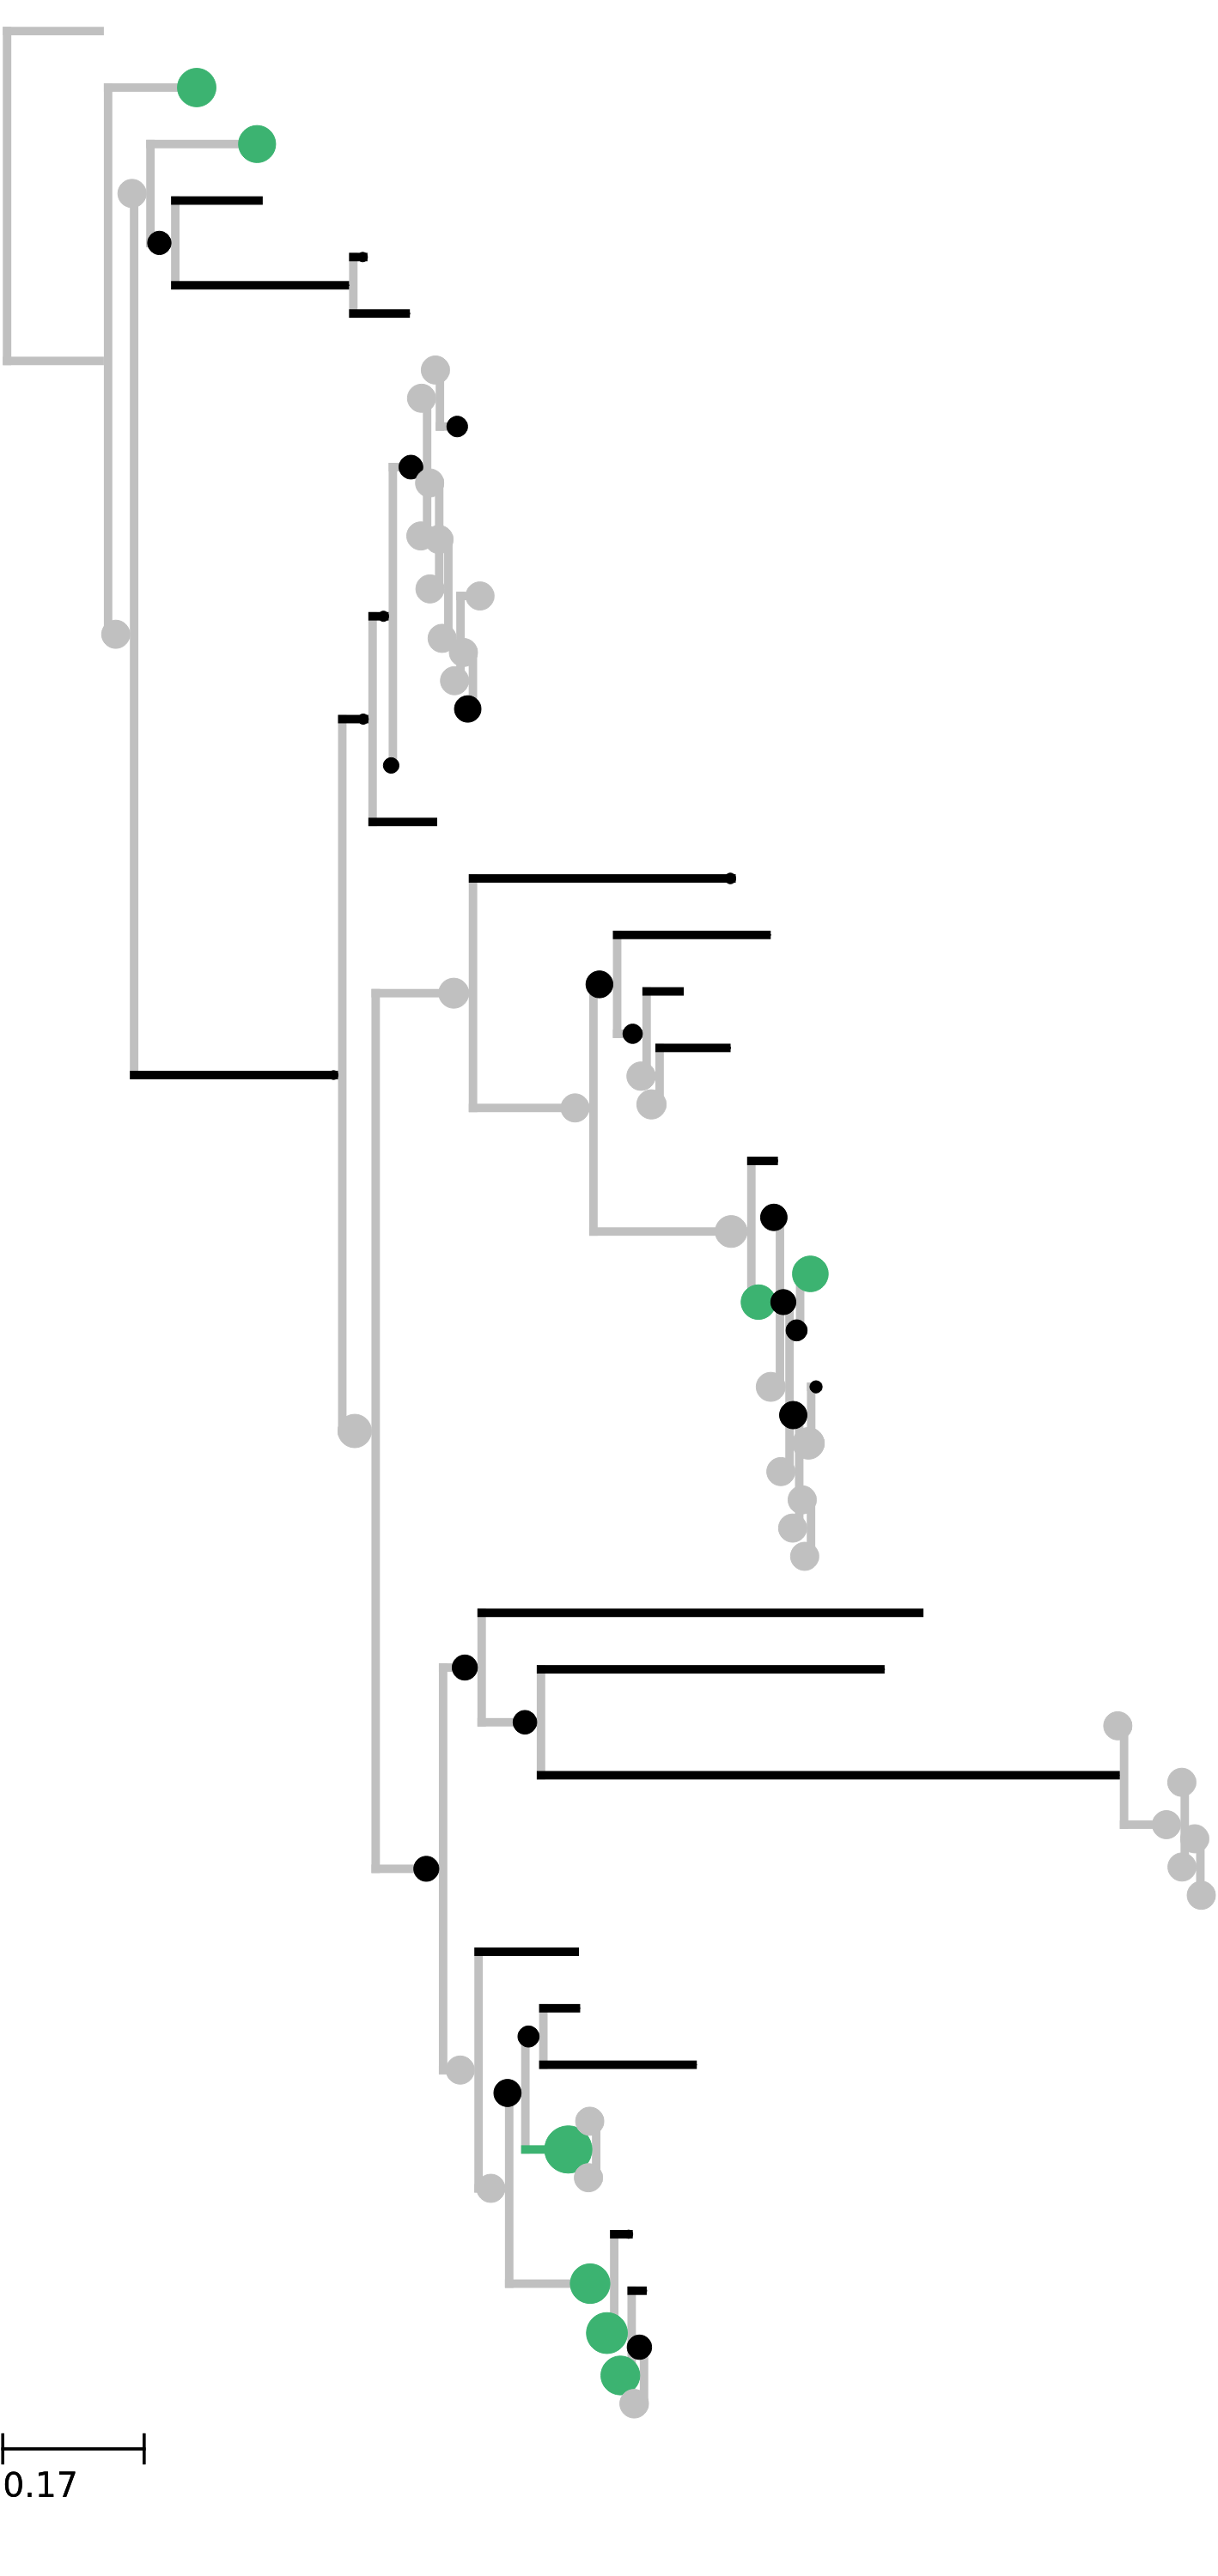

In [13]:
ts = TreeStyle()
ts.scale = 400
ts.min_leaf_separation = 20
ts.show_leaf_name = False
DNA_tree.dist = 0
for n in DNA_tree.traverse():
    ns = NodeStyle()
    ns['size'] = 0
    ns['fgcolor']='white'
    ns['hz_line_width']=3
    ns['vt_line_width']=3
    ns['hz_line_color'] = 'Silver'
    ns['vt_line_color'] = 'Silver'
    if not n.is_root() and not n.up.is_root():# and not n.is_leaf():
        m = np.median(n.ancstateprop)
        color = 'Silver'
        if m > 1.2:
            color = 'mediumseagreen'
        elif m < 0.98:
            color = 'black'
        face = CircleFace(m*5, color)
        pos = 'float'
        n.add_face(face,0,pos)
        if n.dist > 0.01 and m > 1.5:
            ns['hz_line_color'] = 'mediumseagreen'
        elif n.dist > 0.01 and m < 0.5:
            ns['hz_line_color'] = 'black'
    n.set_style(ns)
    if n.is_leaf():
        pos='aligned'
        f_id = pj.fr('18S', filter=[['keep',n.name]])[0].id
        orgn = get_qualifiers_dictionary(pj,f_id)['source_organism']
        #.add_face(TextFace(orgn), 0,'branch-right')
DNA_tree.render('%%inline', h=1000, tree_style=ts)

from IPython.display import Image
Image('independent_contrasts/anc/DNA_tree_anc_change_no_wtsi.png', width=300)

### LTR tree

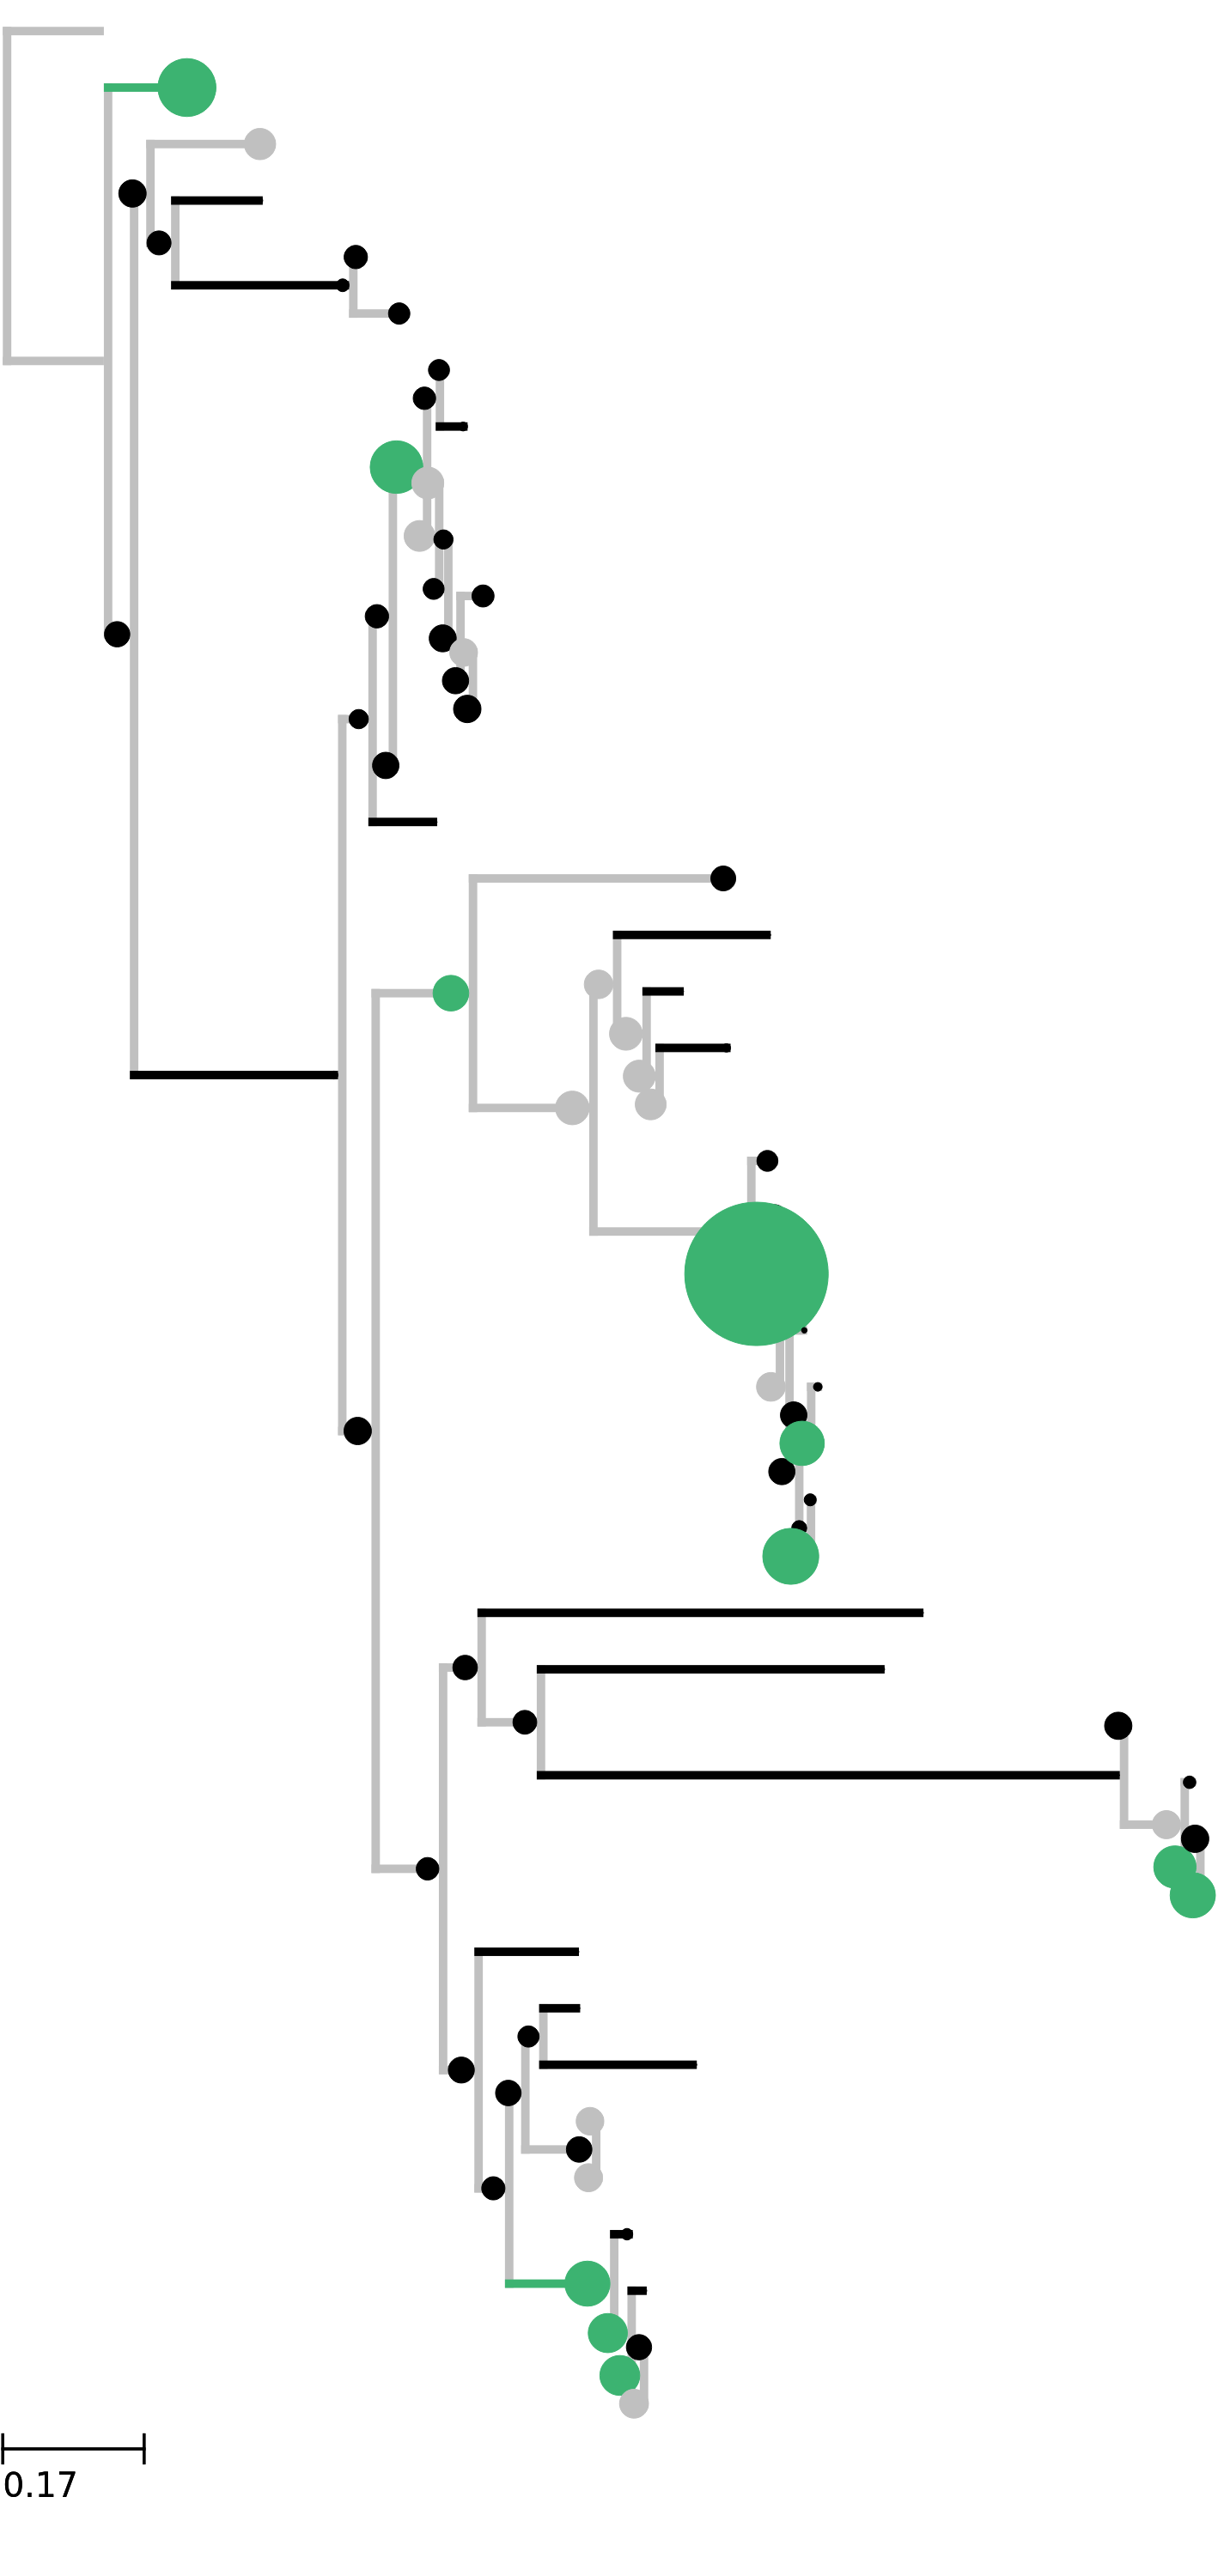

In [16]:
ts = TreeStyle()
ts.scale = 400
ts.show_leaf_name = False
ts.min_leaf_separation = 20
LTR_tree.dist = 0
for n in LTR_tree.traverse():
    ns = NodeStyle()
    ns['size'] = 0
    ns['fgcolor']='white'
    ns['hz_line_width']=3
    ns['vt_line_width']=3
    ns['hz_line_color'] = 'Silver'
    ns['vt_line_color'] = 'Silver'
    if not n.is_root() and not n.up.is_root():# and not n.is_leaf():
        m = np.median(n.ancstateprop)
        color = 'Silver'
        if m > 1.2:
            color = 'mediumseagreen'
        elif m < 0.98:
            color = 'black'
        face = CircleFace(m*5, color)
        pos = 'float'
        n.add_face(face,0,pos)
        if n.dist > 0.01 and m > 1.5:
            ns['hz_line_color'] = 'mediumseagreen'
        elif n.dist > 0.01 and m < 0.5:
            ns['hz_line_color'] = 'black'
    n.set_style(ns)
    if n.is_leaf():
        pos='aligned'
        f_id = pj.fr('18S', filter=[['keep',n.name]])[0].id
        orgn = get_qualifiers_dictionary(pj,f_id)['source_organism']
        #.add_face(TextFace(orgn), 0,'branch-right')
LTR_tree.render('%%inline', h=1000, tree_style=ts)

from IPython.display import Image
Image('independent_contrasts/anc/LTR_anc_change_no_wtsi.png', width=300)

### LINE tree

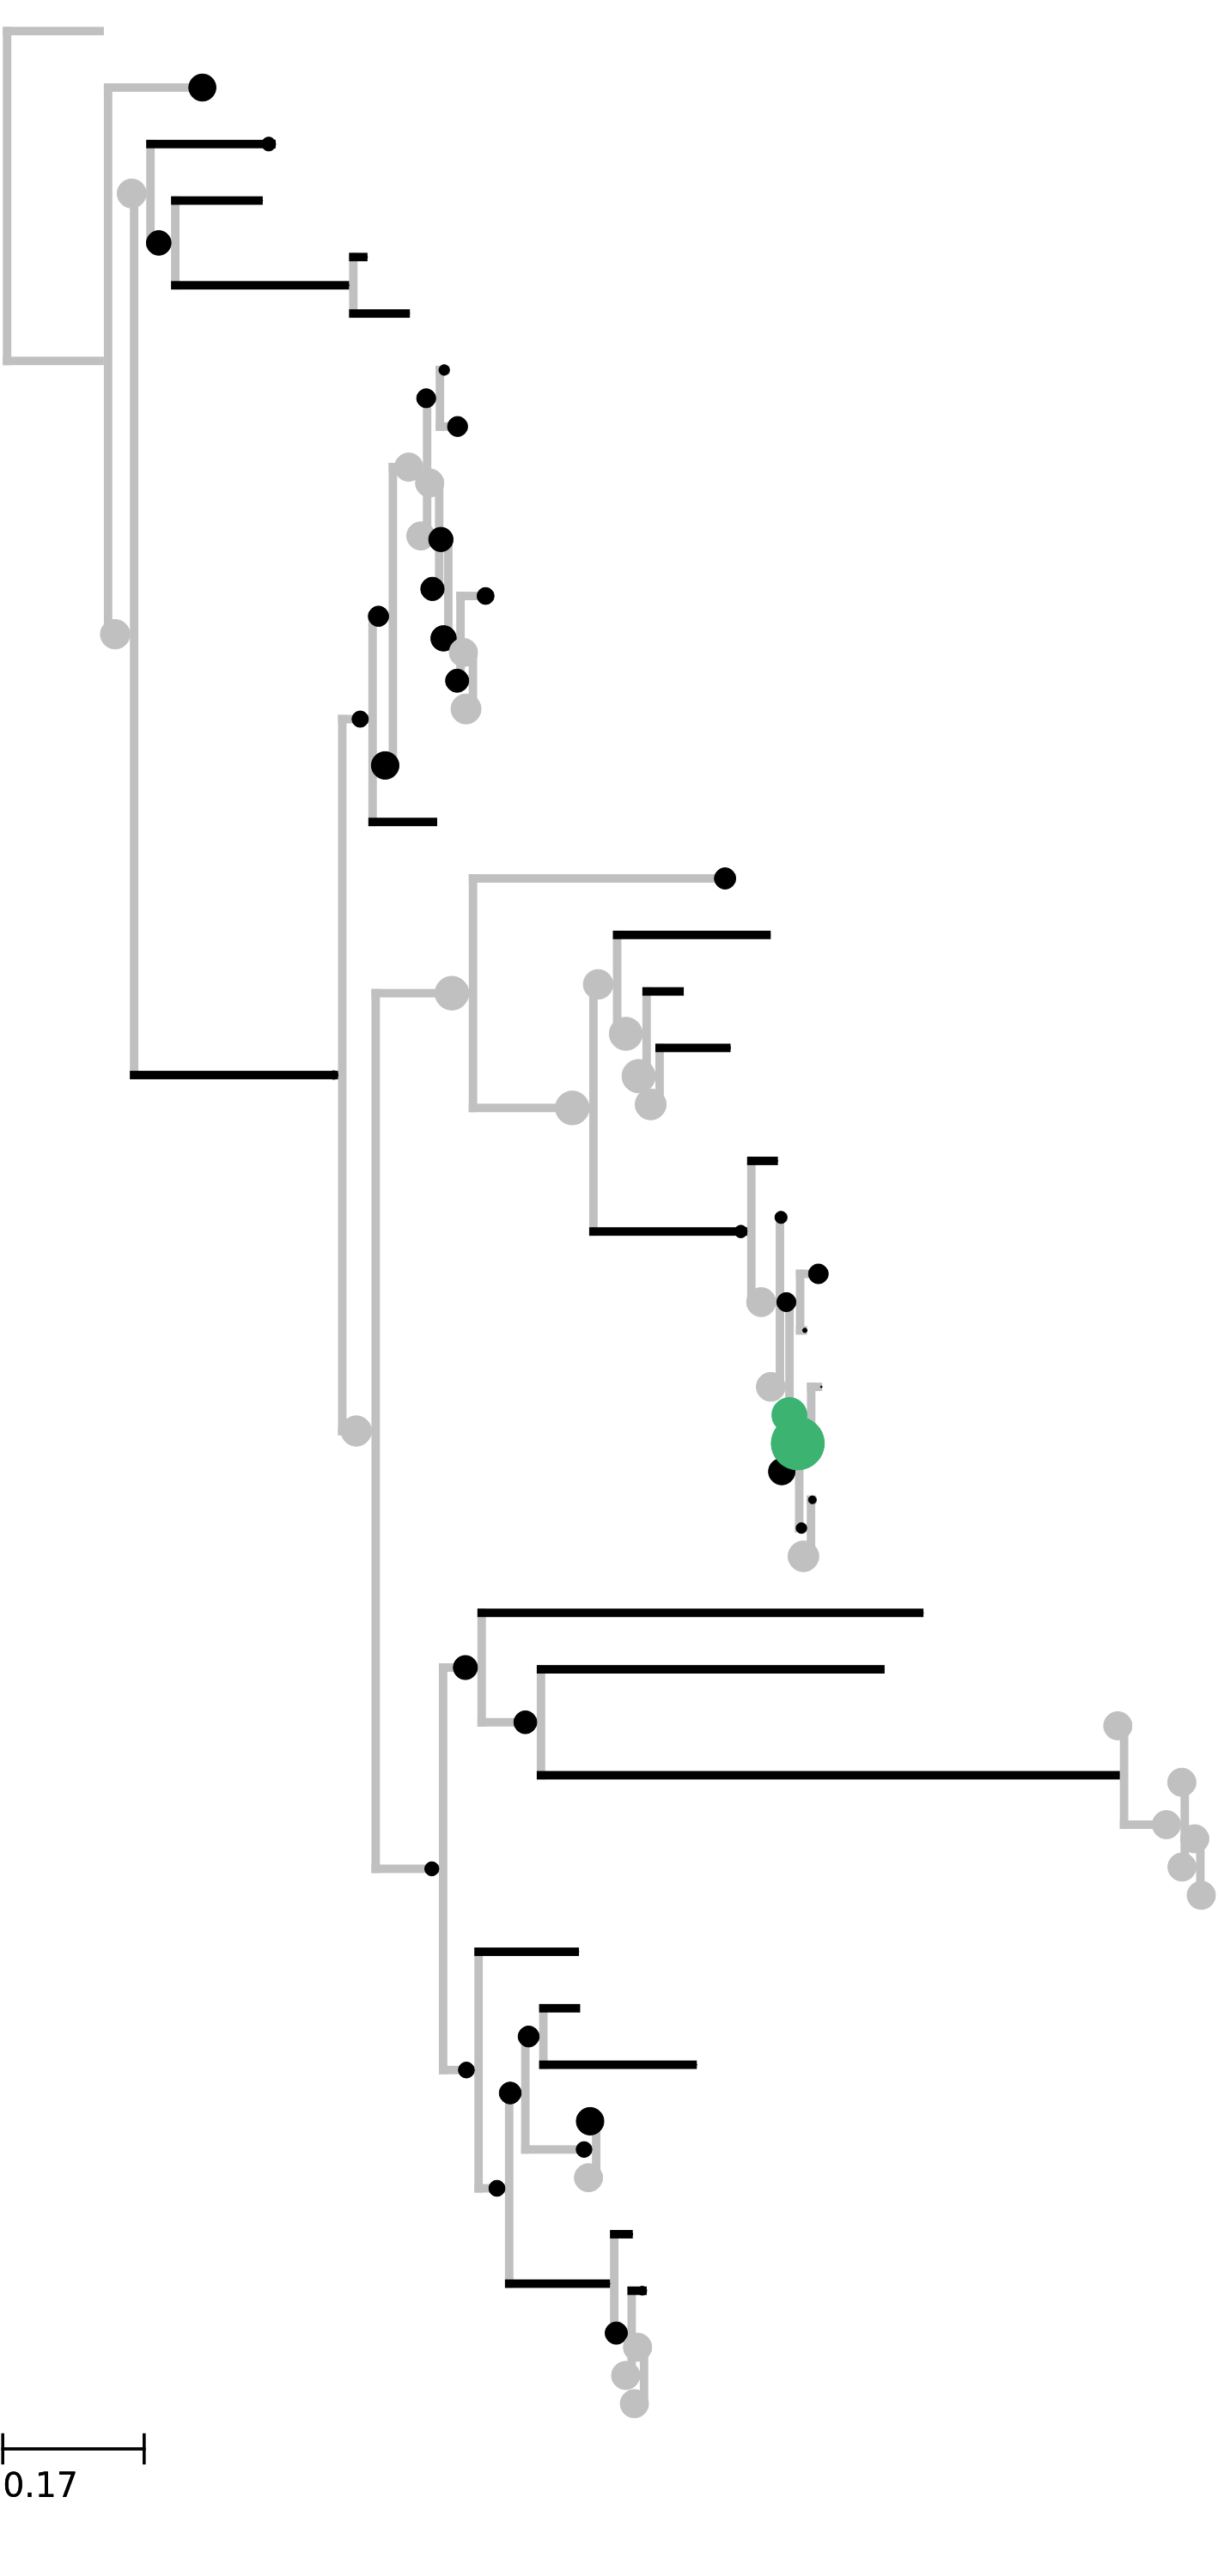

In [18]:
ts = TreeStyle()
ts.scale = 400
ts.min_leaf_separation = 20
ts.show_leaf_name = False
LINE_tree.dist = 0
for n in LINE_tree.traverse():
    ns = NodeStyle()
    ns['size'] = 0
    ns['fgcolor']='white'
    ns['hz_line_width']=3
    ns['vt_line_width']=3
    ns['hz_line_color'] = 'Silver'
    ns['vt_line_color'] = 'Silver'
    if not n.is_root() and not n.up.is_root():# and not n.is_leaf():
        m = np.median(n.ancstateprop)
        color = 'Silver'
        if m > 1.2:
            color = 'mediumseagreen'
        elif m < 0.98:
            color = 'black'
        face = CircleFace(m*5, color)
        pos = 'float'
        n.add_face(face,0,pos)
        if n.dist > 0.01 and m > 1.5:
            ns['hz_line_color'] = 'mediumseagreen'
        elif n.dist > 0.01 and m < 0.5:
            ns['hz_line_color'] = 'black'
    n.set_style(ns)
    if n.is_leaf():
        pos='aligned'
        f_id = pj.fr('18S', filter=[['keep',n.name]])[0].id
        orgn = get_qualifiers_dictionary(pj,f_id)['source_organism']
        #.add_face(TextFace(orgn), 0,'branch-right')
LINE_tree.render('%%inline', h=1000, tree_style=ts)

from IPython.display import Image
Image('independent_contrasts/anc/LINE_anc_change_no_wtsi.png', width=300)

### SINE tree

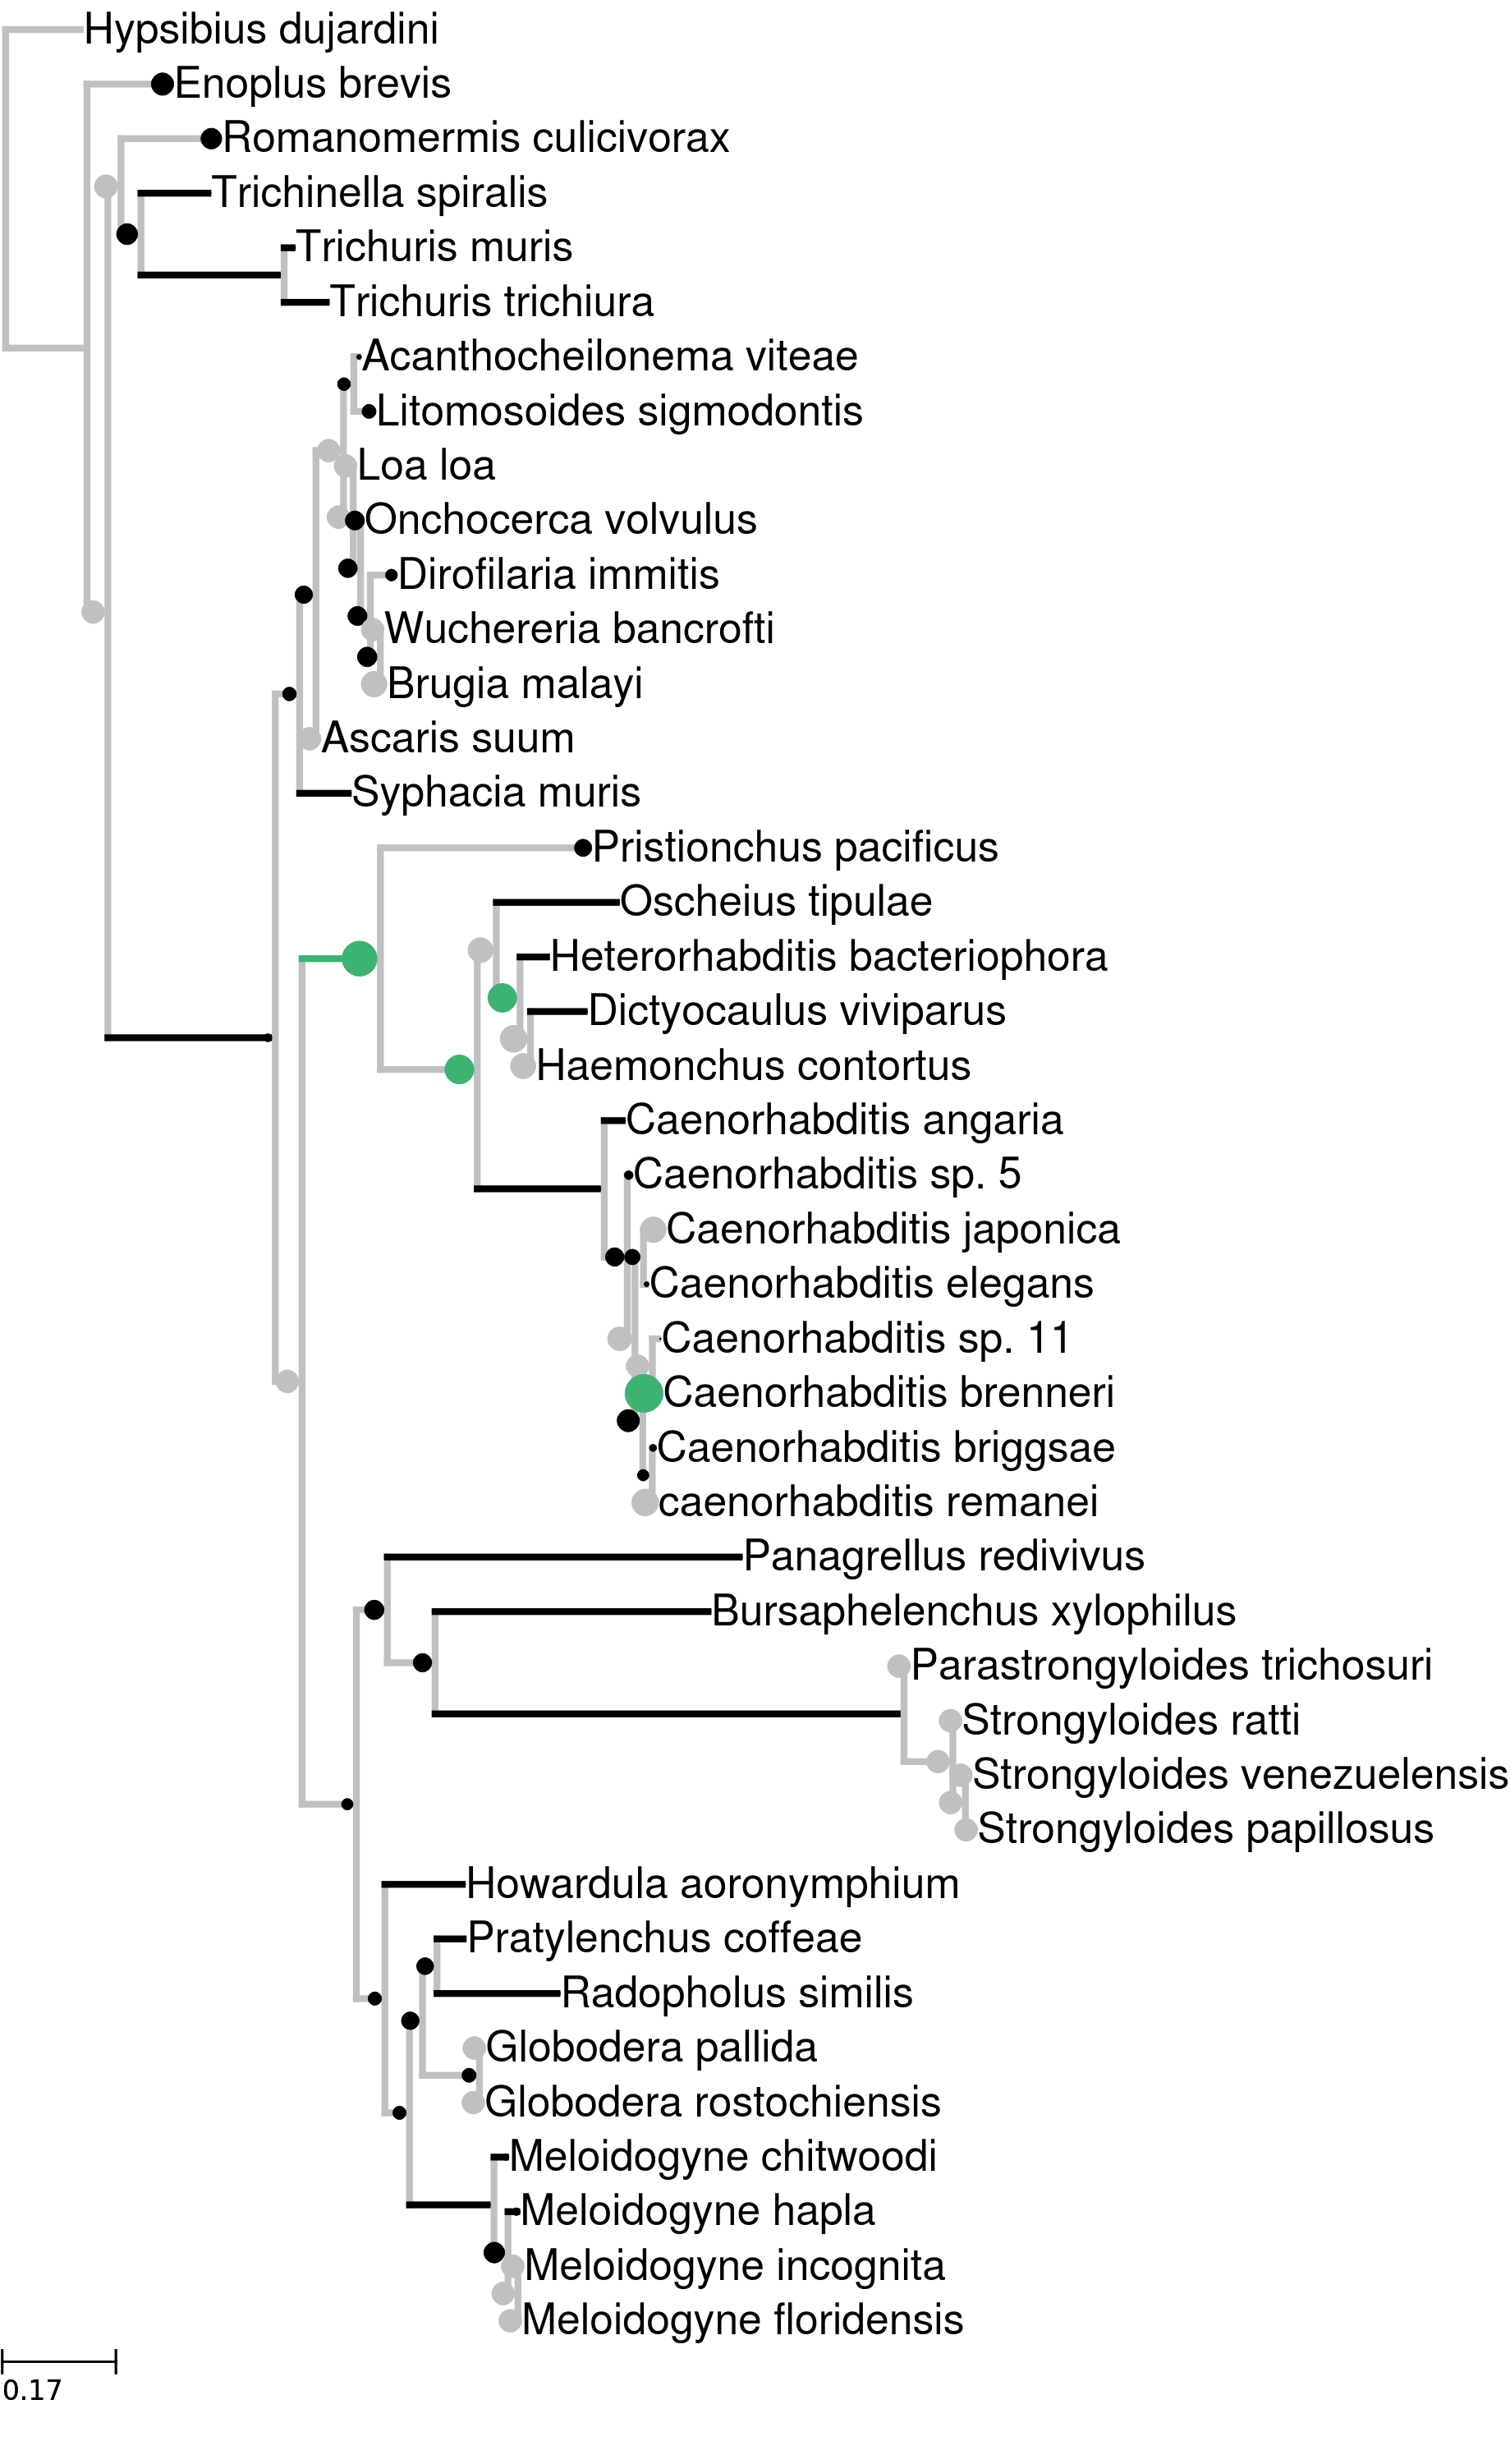

In [20]:
ts = TreeStyle()
ts.scale = 400
ts.min_leaf_separation = 20
ts.show_leaf_name = False
SINE_tree.dist = 0
for n in SINE_tree.traverse():
    ns = NodeStyle()
    ns['size'] = 0
    ns['fgcolor']='white'
    ns['hz_line_width']=3
    ns['vt_line_width']=3
    ns['hz_line_color'] = 'Silver'
    ns['vt_line_color'] = 'Silver'
    if not n.is_root() and not n.up.is_root():# and not n.is_leaf():
        m = np.median(n.ancstateprop)
        color = 'Silver'
        if m > 1.2:
            color = 'mediumseagreen'
        elif m < 0.98:
            color = 'black'
        face = CircleFace(m*5, color)
        pos = 'float'
        n.add_face(face,0,pos)
        if n.dist > 0.01 and m > 1.5:
            ns['hz_line_color'] = 'mediumseagreen'
        elif n.dist > 0.01 and m < 0.5:
            ns['hz_line_color'] = 'black'
    n.set_style(ns)
    if n.is_leaf():
        pos='aligned'
        f_id = pj.fr('18S', filter=[['keep',n.name]])[0].id
        orgn = get_qualifiers_dictionary(pj,f_id)['source_organism']
        n.add_face(TextFace(orgn, fsize=14,ftype='arial'), 0,'branch-right')
SINE_tree.render('%%inline', h=1000, tree_style=ts)

from IPython.display import Image
Image('independent_contrasts/anc/SINE_anc_change_no_wtsi.png', width=300)

### Write Fig 4 components

In [ ]:
ts = TreeStyle()
ts.scale = 300
ts.min_leaf_separation = 20
ts.show_leaf_name = False

for t in [DNA_tree, LTR_tree, LINE_tree, SINE_tree]:
    t.dist=0

DNA_tree.render('independent_contrasts/anc/DNA_tree_anc_change_no_wtsi.png', h=3000, dpi=900, tree_style=ts)
LTR_tree.render('independent_contrasts/anc/LTR_anc_change_no_wtsi.png', h=3000, dpi=900,tree_style=ts)
LINE_tree.render('independent_contrasts/anc/LINE_anc_change_no_wtsi.png', h=3000, dpi=900,tree_style=ts)
ts.scale = 200
SINE_tree.render('independent_contrasts/anc/SINE_anc_change_no_wtsi.png', h=3000, dpi=900,tree_style=ts)